### imports

In [1]:
!pip install tensorflow
!pip install gensim
!pip install tf-keras


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import tensorflow as tf

from gensim.models import Word2Vec
from gensim.models import LsiModel
import gensim

import numpy as np
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sentence_transformers import SentenceTransformer
import json
import contractions
import random

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.metrics import normalized_mutual_info_score

import copy
import statistics

/Users/jadeynfeng/Documents/GitHub/Hons24-Jadeyn/venv/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/Users/jadeynfeng/Documents/GitHub/Hons24-Jadeyn/venv/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


# maintIE inherent function clusters

#### Analysing exceptions with inherent functions 

In [3]:
def analyse_inherent_function_exceptions(row, exception_type=None):
    """Function to analyse exceptions in setting MWO's associated inherent function"""
    # list of tuples of head and tail indices
    hasPart_heads = []
    hasPart_tails = []
    contains_heads =[]
    contains_tails =[]
    isA_relations_indices = []

    for r in row["relations"]:
        if r["type"] == "hasPart":
            hasPart_heads.append(r["head"])
            hasPart_tails.append(r["tail"])
        if r["type"] == "contains":
            contains_heads.append(r["head"])
            contains_tails.append(r["tail"])
        if r["type"] == "isA":
            isA_relations_indices.append((r["head"], r["tail"]))

    # remove any repeats
    hasPart_heads = list(set(hasPart_heads))
    hasPart_tails = list(set(hasPart_tails))
    
    # list of physical object indices not in a hasPart or isA relation
    physical_object_indices = []
    
    # get all physical object indices
    for i in range(len(row["entities"])):
        if row["entities"][i]["type"].split("/")[0] == "PhysicalObject":
            physical_object_indices.append(i)
    
    inherent_function_index = []
    for i in hasPart_tails:
        # if tail is not a head of a hasPart relation
        if i not in hasPart_heads:
            inherent_function_index.append(i)
        # remove tail from the physical object indices
        if i in physical_object_indices:
            physical_object_indices.remove(i)
    
    for i in hasPart_heads:
        # remove head from the physical object indices
        if i in physical_object_indices:
            physical_object_indices.remove(i)

    for i in isA_relations_indices:
        # remove physical objects that are part of an isA relation
        if i[0] in physical_object_indices:
            physical_object_indices.remove(i[0])
        if i[1] in physical_object_indices:
            physical_object_indices.remove(i[1])

    # EXCEPTION 1: if there are physical objects that are not part of a hasPart or isA relation
    if exception_type == "1":
        if physical_object_indices and inherent_function_index:
            print(row)
            for i in physical_object_indices:
                print(row["entities"][i])
            print()
    # EXCEPTION 2: if there is zero, or more than one physical object and no hasPart relation
    elif exception_type == "2":
        # count how many non substance physical objects there are
        ob = []
        for e in row["entities"]:
            if e["type"].split("/")[0] == "PhysicalObject" and (len(e["type"].split("/")) == 1 or (len(e["type"].split("/"))>1 and e["type"].split("/")[1]  != "Substance")):
                ob.append(e)

        if (len(inherent_function_index) == 0) and len(ob)!=1 and not isA_relations_indices:
            print(row)
            print("Number of non-substance Physical Objects:", len(ob))
            if ob:
                print(ob)
            print()
    # EXCEPTION 3: if there are more than one leftover tail from hasPart relations
    if exception_type == "3":
        if (len(inherent_function_index) > 1):
            print(row)
    # EXCEPTION 4: if the head and tail of an isA relation are not the same type
    if exception_type == "4":
        for i in isA_relations_indices:
            if row["entities"][i[0]]["type"] != row["entities"][i[1]]["type"]:
                print(row)
    return

f = open("../data/gold_release.json", "r")
# returns JSON object as a dictionary
data = json.load(f)
f.close()

except_type = input("Enter exception type: ")
MWO_by_function = {}

for datum in data:
    types = [e["type"].split("/")[0] for e in datum["entities"]]
    if ("State" in types or "Process" in types or "Property" in types) and "PhysicalObject" in types:
        analyse_inherent_function_exceptions(datum, exception_type=except_type)

{'text': '<id> blown air conditioner hose to radiator', 'tokens': ['<id>', 'blown', 'air', 'conditioner', 'hose', 'to', 'radiator'], 'entities': [{'start': 1, 'end': 2, 'type': 'State/UndesirableState/FailedState'}, {'start': 2, 'end': 4, 'type': 'PhysicalObject/EmittingObject/ElectricCoolingObject'}, {'start': 4, 'end': 5, 'type': 'PhysicalObject/GuidingObject/ClosedEnclosureGuidingObject'}, {'start': 6, 'end': 7, 'type': 'PhysicalObject/EmittingObject/ThermalEnergyTransferObject'}], 'relations': [{'head': 0, 'tail': 2, 'type': 'hasParticipant/hasPatient'}, {'head': 1, 'tail': 2, 'type': 'hasPart'}]}
{'start': 6, 'end': 7, 'type': 'PhysicalObject/EmittingObject/ThermalEnergyTransferObject'}

{'text': '<id> cabin seals leaking dust PO', 'tokens': ['<id>', 'cabin', 'seals', 'leaking', 'dust', 'PO'], 'entities': [{'start': 1, 'end': 2, 'type': 'PhysicalObject/HoldingObject/EnclosingObject'}, {'start': 2, 'end': 3, 'type': 'PhysicalObject/CoveringObject/InfillingObject'}, {'start': 3, 'en

## Prepare Data

In [3]:
def pad_sequence(dset, max_len=None):
    if not max_len:
        max_len = len(max(dset, key=len))
    print("max length of MWO:", max_len)
    for i in range(len(dset)):
        count = 0
        while len(dset[i]) < max_len:
            dset[i].append(dset[i][count])
            count+=1
    return dset

In [4]:
def clean_tokens(tokens):
    """cleans tokens by removing stopwords and expanding contractions"""
    stopwords =["<num>", "<id>", "-"]
    tokens = [i for i in tokens if i not in stopwords]
    tokens = contractions.fix(" ".join(tokens)).split()
    return tokens

In [6]:
def extract_function_from_entity_index(row, index, equipment_dict=None):
    """extracts the function from an PhysicalObject's index"""
    if equipment_dict:
        start = row["entities"][index]["start"]
        end = row["entities"][index]["end"]
        equipment = " ".join([row["tokens"][i] for i in range(start, end)])
        if equipment not in equipment_dict.keys():
            return None
        return equipment_dict[equipment][:-6].lower()
    types = row["entities"][index]["type"].split("/")
    if len(types) > 1:
        return types[1][:-6].lower()
    else:
        return None
    
def get_inherent_function(row, equipment_dict=None):
    """choose the most appropriate inherent function to do with the failure mode of a MWO"""
    # list of tuples of head and tail indices
    hasPart_heads = []
    hasPart_tails = []
    contains_heads =[]
    contains_tails =[]
    isA_relations_indices = []

    for r in row["relations"]:
        if r["type"] == "hasPart":
            hasPart_heads.append(r["head"])
            hasPart_tails.append(r["tail"])
        if r["type"] == "contains":
            contains_heads.append(r["head"])
            contains_tails.append(r["tail"])
        if r["type"] == "isA":
            isA_relations_indices.append((r["head"], r["tail"]))

    # remove any repeats
    hasPart_heads = list(set(hasPart_heads))
    hasPart_tails = list(set(hasPart_tails))
    
    # list of physical object indices not in a hasPart or isA relation
    physical_object_indices = []
    
    # get all physical object indices
    for i in range(len(row["entities"])):
        if row["entities"][i]["type"].split("/")[0] == "PhysicalObject" and (equipment_dict or len(row["entities"][i]["type"].split("/")) == 1 or (row["entities"][i]["type"].split("/")[1]  != "Substance")):
            physical_object_indices.append(i)
    
    inherent_function_index = []
    for i in hasPart_tails:
        # if tail is not a head of a hasPart relation
        if i not in hasPart_heads:
            inherent_function_index.append(i)
        # remove tail from the physical object indices
        if i in physical_object_indices:
            physical_object_indices.remove(i)
    
    for i in hasPart_heads:
        # remove head from the physical object indices
        if i in physical_object_indices:
            physical_object_indices.remove(i)

    for i in isA_relations_indices:
        # remove physical objects that are part of an isA relation
        if i[0] in physical_object_indices:
            physical_object_indices.remove(i[0])
        if i[1] in physical_object_indices:
            physical_object_indices.remove(i[1])

    # EXCEPTION 1: if there are physical objects that are not part of a hasPart or isA relation, and there is a hasPart relation
    if physical_object_indices and inherent_function_index:
        # in general, ignore additional physical objects 
        if len(inherent_function_index) ==1:
            isA_tails = [i[1] for i in isA_relations_indices]
            # if there is a more specific (head) object in an isA relation
            if inherent_function_index[0] in isA_tails:
                isA_head_index = isA_relations_indices[isA_tails.index(inherent_function_index[0])][0]
                func = extract_function_from_entity_index(row, isA_head_index, equipment_dict)
                return func
            else:
                func = extract_function_from_entity_index(row, inherent_function_index[0], equipment_dict)
                return func


    # EXCEPTION 2: if there is zero or more than one physical object and no hasPart relations
    if (len(inherent_function_index) == 0) and len(physical_object_indices)!=1 and not isA_relations_indices:
        # if there are no physical objects, remove the row
        if len(physical_object_indices) == 0:
            print("remove:",row, "\n")
            return None
        physical_object_not_substance = []
        for i in physical_object_indices:
            start = row["entities"][i]["start"]
            end = row["entities"][i]["end"]
            # if the physical object is not a substance
            if end == len(row["tokens"]) and " ".join(row["tokens"][start:]) != "oil":
                physical_object_not_substance.append(i)
            elif " ".join(row["tokens"][start:end]) != "oil":
                physical_object_not_substance.append(i)

        # if there is only one non-substance physical object, extract its function
        if len(physical_object_not_substance) == 1:
            func = extract_function_from_entity_index(row, physical_object_not_substance[0], equipment_dict)
            return func
        else:
            func = extract_function_from_entity_index(row, physical_object_indices[0], equipment_dict)
            return func
            
                

    # EXCEPTION 3: if there are more than one leftover tail from hasPart relations
    if (len(inherent_function_index) > 1):
        # manually assign inherent function
        if row["text"] == "replace unserviceable transmission screen and magnet":
            return "transforming"
        elif row["text"] == "pump drive box coupling and shaft unserviceable":
            return "driving"
        else:
            return None
    

    # get entities
    if len(inherent_function_index) == 1 and len(physical_object_indices) == 0:
        func = extract_function_from_entity_index(row, inherent_function_index[0], equipment_dict)
        return func
    elif len(inherent_function_index) == 0 and len(physical_object_indices) == 1:
        func = extract_function_from_entity_index(row, physical_object_indices[0], equipment_dict)
        return func
    elif all(i in [x for xs in isA_relations_indices for x in xs] for i in physical_object_indices):
        isA_heads = [i[0] for i in isA_relations_indices]
        isA_tails = [i[1] for i in isA_relations_indices]
        isA_specific_indices = []
        for i in isA_heads:
            if i not in isA_tails:
                isA_specific_indices.append(i)
        if len(isA_specific_indices) == 1:
            func = extract_function_from_entity_index(row, isA_specific_indices[0], equipment_dict)
            return func
        
        else:
            if row["text"] == "<id> park brake alarm fault":
                return "restricting"
            else:
                return None
               
    elif len(inherent_function_index)>1:
        return None
       
    else:
        return None
        
    
    

def get_gold_dataset(dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO):
    """get the gold dataset and its inherent function labels"""
    f = open("../data/gold_release_filtered3.json", "r")
    # returns JSON object as a dictionary
    data = json.load(f)
    f.close()


    for datum in data:
        types = [e["type"].split("/")[0] for e in datum["entities"]]
        if ("State" in types or "Process" in types or "Property" in types) and "PhysicalObject" in types:
            inherent_function = get_inherent_function(datum)
            if not inherent_function:
                continue

            tokens = datum["tokens"].copy()

            # remove activity tokens
            if "Activity" in types:
                activity_indices = []
                for e in datum["entities"]:
                    if e["type"].split("/")[0] == "Activity":
                        for i in range(e["start"], e["end"]):
                            activity_indices.append(i)
                activity_indices = sorted(set(activity_indices), reverse=True)
                for i in activity_indices:
                    tokens.pop(i)
                

            tokens = clean_tokens(tokens)
            dataset.append(tokens)
            if inherent_function not in class_list:
                labels.append(len(class_list))
                class_list.append(inherent_function)
            else:
                labels.append(class_list.index(inherent_function))
            
            # add MWO tokens to dictionary with key inherent function
            if inherent_function in MWO_by_function:
                MWO_by_function[inherent_function].append(tokens)
            else:
                MWO_by_function[inherent_function] = [tokens]
            
            # add state, equipment, and inherent function to dictionary with key MWO
            mwo = " ".join(tokens)
            if mwo not in state_equipment_inherentfunction_by_MWO:
                states = []
                equip = []
                for i in range(len(types)):
                    if types[i] in ["State", "Process", "Property"]:
                        start = datum["entities"][i]["start"]
                        end = datum["entities"][i]["end"]
                        states.append(" ".join([datum["tokens"][j] for j in range(start, end)]))
                    elif types[i] == "PhysicalObject":
                        start = datum["entities"][i]["start"]
                        end = datum["entities"][i]["end"]
                        equip.append(" ".join([datum["tokens"][j] for j in range(start, end)]))
                state_equipment_inherentfunction_by_MWO[mwo]=[states, equip, inherent_function]

    print("Number of Inherent function clusters:", len(MWO_by_function.keys()))
    for i in MWO_by_function.keys():
        print(i, len(MWO_by_function[i]))
        if len(MWO_by_function[i]) == 1:
            print("   ", MWO_by_function[i])
    print()
    return dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO

In [7]:
def create_equipment_dictionary():
    """create a dictionary of known equipment and their inherent functions"""
    f = open("../data/gold_release_filtered3.json", "r")
    # returns JSON object as a dictionary
    data = json.load(f)
    f.close()

    
    # exception multiple types for the same equipment
    ignored_equipment = {"auto-lube":"ProtectingObject", "axle":"GuidingObject", "drag":"MatterProcessingObject", "universal joint":"GuidingObject", "adaptor":"InterfacingObject", "batteries":"StoringObject", "carousel":"StoringObject", "window":"RestrictingObject", "shaft":"GuidingObject", "input shaft":"GuidingObject"}
    equipment = ignored_equipment.copy()
    
    for datum in data:
        for e in datum["entities"]:
            entity_type = e["type"].split("/")
            if entity_type[0] == "PhysicalObject" and len(entity_type) > 1 and entity_type[1] not in ["Substance", "Organism"]:
                start = int(e["start"])
                end = int(e["end"])
                equipment_text = " ".join([datum["tokens"][t] for t in range(start, end)])
                
                if equipment_text in ignored_equipment:
                    continue
                if equipment_text not in equipment:
                    equipment[equipment_text] = entity_type[1]
              
    return equipment

def get_synthetic_dataset(filename, dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO):
    """Get synthetic dataset and its inherent function labels"""
    import csv


    with open(filename, 'r') as csvfile:
        # creating a csv reader object
        csvreader = csv.reader(csvfile)
        counter = 0
        for row in csvreader:
            tokens = row[0].split()
            if len(row[1].split("/")) == 1 or row[1].split("/")[1] in ["Substance", "Organism", "GuidingObject","HoldingObject"] or "leak" in row[3]:
                counter+=1
                continue
            inherent_function = row[1].split("/")[1][:-6].lower()

            tokens = clean_tokens(tokens)
            dataset.append(tokens)
            if inherent_function not in class_list:
                labels.append(len(class_list))
                class_list.append(inherent_function)
            else:
                labels.append(class_list.index(inherent_function))
            
            # add MWO tokens to dictionary with key inherent function
            if inherent_function in MWO_by_function:
                MWO_by_function[inherent_function].append(tokens)
            else:
                MWO_by_function[inherent_function] = [tokens]
            
            mwo= " ".join(tokens)
            # add state, equipment, inherent function to dictionary with key tokens
            if mwo not in state_equipment_inherentfunction_by_MWO:
                states = []
                equip = []
                states.append(row[3])
                equip.append(row[2])
                state_equipment_inherentfunction_by_MWO[mwo]=[states, equip, inherent_function]

    print("Number of Inherent function clusters:", len(MWO_by_function.keys()))
    for i in MWO_by_function.keys():
        print(i, len(MWO_by_function[i]))
        if len(MWO_by_function[i]) == 1:
            print("   ", MWO_by_function[i])
    print()

    return dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO
            
    
def get_silver_dataset(dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO):
    """get the silver dataset and its inherent function labels"""
    equipment_dict = create_equipment_dictionary()
    
    f = open("../data/silver_release_filtered3.json", "r")
    # returns JSON object as a dictionary
    data = json.load(f)
    f.close()

    for datum in data:
        types = [e["type"].split("/")[0] for e in datum["entities"]]
        if ("State" in types or "Process" in types or "Property" in types) and "PhysicalObject" in types:
            inherent_function = get_inherent_function(datum, equipment_dict)
            if not inherent_function:
                continue
            
            tokens = datum["tokens"].copy()

            # remove activity tokens
            if "Activity" in types:
                activity_indices = []
                for e in datum["entities"]:
                    if e["type"].split("/")[0] == "Activity":
                        for i in range(e["start"], e["end"]):
                            activity_indices.append(i)
                activity_indices = sorted(set(activity_indices), reverse=True)
                for i in activity_indices:
                    tokens.pop(i)
            
            tokens = clean_tokens(tokens)
            dataset.append(tokens)
            if inherent_function not in class_list:
                labels.append(len(class_list))
                class_list.append(inherent_function)
            else:
                labels.append(class_list.index(inherent_function))
            
            # add MWO tokens to dictionary with key inherent function
            if inherent_function in MWO_by_function:
                MWO_by_function[inherent_function].append(tokens)
            else:
                MWO_by_function[inherent_function] = [tokens]
            
            mwo= " ".join(tokens)
            # add state, equipment, inherent function to dictionary with key tokens
            if mwo not in state_equipment_inherentfunction_by_MWO:
                states = []
                equip = []
                for i in range(len(types)):
                    if types[i] in ["State", "Process", "Property"]:
                        start = datum["entities"][i]["start"]
                        end = datum["entities"][i]["end"]
                        states.append(" ".join([datum["tokens"][j] for j in range(start, end)]))
                    elif types[i] == "PhysicalObject":
                        start = datum["entities"][i]["start"]
                        end = datum["entities"][i]["end"]
                        equip.append(" ".join([datum["tokens"][j] for j in range(start, end)]))
                state_equipment_inherentfunction_by_MWO[mwo]=[states, equip, inherent_function]


    print("Number of Inherent function clusters:", len(MWO_by_function.keys()))
    for i in MWO_by_function.keys():
        print(i, len(MWO_by_function[i]))
        if len(MWO_by_function[i]) == 1:
            print("   ", MWO_by_function[i])
    print()
    return dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO


In [8]:
def create_dataset():
    """create the dataset of gold, silver and synthetic data"""
    MWO_by_function = {}
    dataset = []
    labels = []
    class_list = []
    state_equipment_inherentfunction_by_MWO = {}

    dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO = get_gold_dataset(dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO)
    # dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO = get_synthetic_dataset("../data/synthetic2.csv",dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO)
    dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO = get_silver_dataset(dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO)

    return dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO


In [9]:
dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO = create_dataset()

# remove information processing
for i in MWO_by_function["informationprocessing"]:
    if i in dataset:
        print("Removed")
        print(i)
        dataset.remove(i)
labels = [i for i in labels if i != 16] 

# divide dataset into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, random_state=42, shuffle=True, test_size=0.2)
y_train = np.array(y_train)
y_test = np.array(y_test)
X = X_train + X_test

print("training set length:",len( X_train))
print("test set length:", len(X_test))
print("dataset length:",len( dataset))

remove: {'text': '<id> air leak', 'tokens': ['<id>', 'air', 'leak'], 'entities': [{'start': 1, 'end': 2, 'type': 'PhysicalObject/Substance/Gas'}, {'start': 2, 'end': 3, 'type': 'Process/UndesirableProcess'}], 'relations': [{'head': 1, 'tail': 0, 'type': 'hasParticipant/hasPatient'}]} 

remove: {'text': '<id> - air leak', 'tokens': ['<id>', '-', 'air', 'leak'], 'entities': [{'start': 2, 'end': 3, 'type': 'PhysicalObject/Substance/Gas'}, {'start': 3, 'end': 4, 'type': 'Process/UndesirableProcess'}], 'relations': [{'head': 1, 'tail': 0, 'type': 'hasParticipant/hasPatient'}]} 

remove: {'text': '<id> - fuel leak', 'tokens': ['<id>', '-', 'fuel', 'leak'], 'entities': [{'start': 2, 'end': 3, 'type': 'PhysicalObject/Substance/Liquid'}, {'start': 3, 'end': 4, 'type': 'Process/UndesirableProcess'}], 'relations': [{'head': 1, 'tail': 0, 'type': 'hasParticipant/hasPatient'}]} 

remove: {'text': '<id> <id> replace hydraulic oil leak text', 'tokens': ['<id>', '<id>', 'replace', 'hydraulic', 'oil', 

## Create Semantic embeddings

In [10]:
def w2v_embed(xtrain,xtest, max_len):
    """get Word2Vec embeddings for the dataset"""
    # Word2Vec embeddings as input
    x_copy_train = copy.deepcopy(xtrain)
    x_copy_test = copy.deepcopy(xtest)
    padded_x_train = pad_sequence(x_copy_train, max_len)
    padded_x_test = pad_sequence(x_copy_test, max_len)
    padded_x = padded_x_train + padded_x_test

    w2vmodel = gensim.models.Word2Vec(padded_x, min_count=1, vector_size=100,
                                    window=5, sg=1)


    w2v_embeddings_train = []
    for sentence in padded_x_train:
        row = []
        for word in sentence:
            row.append(w2vmodel.wv[word])
        w2v_embeddings_train.append(row)
    w2v_embeddings_train = np.array(w2v_embeddings_train)

    w2v_embeddings_test = []
    for sentence in padded_x_test:
        row = []
        for word in sentence:
            row.append(w2vmodel.wv[word])
        w2v_embeddings_test.append(row)
    w2v_embeddings_test = np.array(w2v_embeddings_test)
    return w2v_embeddings_train, w2v_embeddings_test

max_len = len(max(dataset, key=len))
w2v_embeddings_X_train, w2v_embeddings_X_test = w2v_embed(X_train, X_test, max_len)

print(w2v_embeddings_X_train.shape)
print(w2v_embeddings_X_test.shape)

max length of MWO: 10
max length of MWO: 10
(1584, 10, 100)
(397, 10, 100)


In [11]:
# SBERT embeddings
sbert = SentenceTransformer("all-mpnet-base-v2")
SBERT_embeddings_train = sbert.encode(X_train)
SBERT_embeddings_test = sbert.encode(X_test)

print(SBERT_embeddings_train.shape)
print(SBERT_embeddings_test.shape)

(1584, 768)
(397, 768)


## Clustering Helper Functions

In [12]:
def print_cluster_stats(all_inherentfunc_occurrences):
    """print statistics of the clusters"""
    # get top words    
    print()
    print()
    print("Ave number of documents per cluster:", sum([sum(i) for i in all_inherentfunc_occurrences])/len(all_inherentfunc_occurrences))
    print("Median number of documents per cluster:", statistics.median([sum(i) for i in all_inherentfunc_occurrences]))
    print("Min number of documents per cluster:", min([sum(i) for i in all_inherentfunc_occurrences]))
    print("Max number of documents per cluster:", max([sum(i) for i in all_inherentfunc_occurrences]))
    print()
    one_func = [i for i in all_inherentfunc_occurrences if i[0]/sum(i) >= 0.8]
    print("Percentage of clusters with 1 main Inherent function (80% of docs):", len(one_func)/len(all_inherentfunc_occurrences))

    two_three_func = [i for i in all_inherentfunc_occurrences if sum(i[:3])/sum(i) >= 0.8 and i[0]/sum(i) < 0.8]
    print("Percentage of clusters with 2 or 3 main Inherent functions (80% of docs):", len(two_three_func)/len(all_inherentfunc_occurrences))

    print("Percentage of documents in clusters with 1 main Inherent function (80% of docs):", sum(sum(one_func,[]))/len(dataset))
    print("Percentage of documents in clusters with 2 or 3 main Inherent functions (80% of docs):", sum(sum(two_three_func,[]))/len(dataset))

### K means

In [13]:
def perform_kmeans(cluster_embeddings):
    # PCA reduction
    pca = PCA(n_components=2)
    pca_embedding = pca.fit_transform(cluster_embeddings)
    plt.scatter(pca_embedding[:,0], pca_embedding[:,1])
    plt.title("PCA")
    plt.show()

    # tsne reduction
    tsne = TSNE(n_components=2).fit_transform(cluster_embeddings)
    plt.scatter(tsne[:,0], tsne[:,1])
    plt.title("TSNE")
    plt.show()


    # Perform kmean clustering
    silhouette_scores = []
    test_k = list(range(5, 50))
    for i in test_k:
        print(i, "/", 50)
        kmeans = KMeans(n_clusters=i, random_state=42, n_init=100).fit(cluster_embeddings)
        labels = kmeans.labels_
        silhouette_scores.append(silhouette_score(cluster_embeddings, labels))
        if i == 16:
            nmi = normalized_mutual_info_score(labels, y_train.tolist()+y_test.tolist())
    plt.plot(test_k, silhouette_scores)
    plt.title("Silhouette Scores")
    plt.show()
    
    print("NMI:",nmi)


def run_kmeans_best_k(k, cluster_embeddings):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=100).fit(cluster_embeddings)
    cluster_labels = kmeans.labels_
    all_inherentfunc_occurrences = []

    for i in range(1,k+1):
        print("Cluster",i,":")
        cluster_docs = []
        cluster_words = {}
        cluster_states={}
        cluster_equip={}
        cluster_inherentfunc={}
        for j in range(len(cluster_labels)):
            if cluster_labels[j]==(i-1):
                mwo = " ".join(X[j])
                cluster_docs.append(mwo)

                for word in X[j]:
                    if word in cluster_words:
                        cluster_words[word]+=1
                    else:
                        cluster_words[word]=1
                
                state_equip_inherfunc = state_equipment_inherentfunction_by_MWO[mwo]
                for state in state_equip_inherfunc[0]:
                    if state in cluster_states:
                        cluster_states[state]+=1
                    else:
                        cluster_states[state]=1
                for equip in state_equip_inherfunc[1]:
                    if equip in cluster_equip:
                        cluster_equip[equip]+=1
                    else:
                        cluster_equip[equip]=1
                if state_equip_inherfunc[2] in cluster_inherentfunc:
                    cluster_inherentfunc[state_equip_inherfunc[2]]+=1
                else:
                    cluster_inherentfunc[state_equip_inherfunc[2]]=1
        
        # get top words
        print("Cluster Size:=========", len(cluster_labels[cluster_labels==i-1]))
        print("Sample Docs:=========")
        if len(cluster_docs) > 0:
            for j in random.sample(cluster_docs, min(5, len(cluster_docs))):
                print(j)
        else:
            print("No docs")
        print()
        print("Top words:=========")
        sorted_cluster_words = sorted(cluster_words, key=cluster_words.get, reverse=True)
        for j in range(min(len(sorted_cluster_words), 5)):
            print(sorted_cluster_words[j])
        print()
        sorted_cluster_states = sorted(cluster_states, key=cluster_states.get, reverse=True)
        print("Top failure modes:=========")
        for j in range(min(len(sorted_cluster_states), 5)):
            print(sorted_cluster_states[j])
        print()

        sorted_cluster_equip = sorted(cluster_equip, key=cluster_equip.get, reverse=True)
        print("Top equipment:=========")
        for j in range(min(len(sorted_cluster_equip), 5)):
            print(sorted_cluster_equip[j])
        print()

        sorted_cluster_inherentfunc = sorted(cluster_inherentfunc, key=cluster_inherentfunc.get, reverse=True)
        inherentfunc_occurrences= []
        print("Inherent functions in order:")
        for j in range(len(sorted_cluster_inherentfunc)):
            sentence = sorted_cluster_inherentfunc[j] +" (" + str(cluster_inherentfunc[sorted_cluster_inherentfunc[j]]) +")"
            print(sentence)
            inherentfunc_occurrences.append(cluster_inherentfunc[sorted_cluster_inherentfunc[j]])
        all_inherentfunc_occurrences.append(inherentfunc_occurrences)
        print("==================================================\n")

    print_cluster_stats(all_inherentfunc_occurrences)

### Hierarchical Clustering

In [37]:
def perform_hierarchical_clustering(cluster_embeddings, method):
    linkage_data = linkage(cluster_embeddings, method=method)
    fig = plt.figure(figsize=(25, 10))
    dn = dendrogram(linkage_data)
    plt.show()

    # calculate sihouette score on different k values
    silhouette_scores = []
    test_k = list(range(2, 50))
    nmi = 0
    for i in test_k:
        cluster_labels = fcluster(linkage_data, i, criterion='maxclust')
        silhouette_scores.append(silhouette_score(cluster_embeddings, cluster_labels))
        if i == 16:
            nmi = normalized_mutual_info_score(cluster_labels, y_train.tolist()+y_test.tolist())
    plt.plot(test_k, silhouette_scores, marker='o')
    plt.title("Silhouette Scores")
    plt.show()

    print("NMI:",nmi)

    return linkage_data


def get_hierarchical_clusters(k, linkage_data):
    cluster_labels = fcluster(linkage_data, k, criterion='maxclust')
    all_inherentfunc_occurrences = []
    for i in range(1,k+1):
        print("Cluster",i,":")
        cluster_docs = []
        cluster_words = {}
        cluster_states={}
        cluster_equip={}
        cluster_inherentfunc={}
        for j in range(len(cluster_labels)):
            if cluster_labels[j]==i:
                mwo = " ".join(X[j])
                cluster_docs.append(mwo)
                for word in X[j]:
                    if word in cluster_words:
                        cluster_words[word]+=1
                    else:
                        cluster_words[word]=1
        
                state_equip_inherfunc = state_equipment_inherentfunction_by_MWO[mwo]
                for state in state_equip_inherfunc[0]:
                    if state in cluster_states:
                        cluster_states[state]+=1
                    else:
                        cluster_states[state]=1
                for equip in state_equip_inherfunc[1]:
                    if equip in cluster_equip:
                        cluster_equip[equip]+=1
                    else:
                        cluster_equip[equip]=1
                if state_equip_inherfunc[2] in cluster_inherentfunc:
                    cluster_inherentfunc[state_equip_inherfunc[2]]+=1
                else:
                    cluster_inherentfunc[state_equip_inherfunc[2]]=1
        

        # get top words
        print("Cluster Size:=========", len(cluster_labels[cluster_labels==i]))
        print("Sample Docs:=========")
        if len(cluster_docs) > 0:
            for j in random.sample(cluster_docs, min(10, len(cluster_docs))):
                print(j)
        else:
            print("No docs")
        print()
        print("Top words:=========")
        sorted_cluster_words = sorted(cluster_words, key=cluster_words.get, reverse=True)
        for j in range(min(len(sorted_cluster_words), 5)):
            print(sorted_cluster_words[j])
        print()
        sorted_cluster_states = sorted(cluster_states, key=cluster_states.get, reverse=True)
        print("Top failure modes:=========")
        for j in range(min(len(sorted_cluster_states), 5)):
            print(sorted_cluster_states[j])
        print()

        sorted_cluster_equip = sorted(cluster_equip, key=cluster_equip.get, reverse=True)
        print("Top equipment:=========")
        for j in range(min(len(sorted_cluster_equip), 5)):
            print(sorted_cluster_equip[j])
        print()

        sorted_cluster_inherentfunc = sorted(cluster_inherentfunc, key=cluster_inherentfunc.get, reverse=True)
        inherentfunc_occurrences = []
        print("Inherent functions in order:")
        for j in range(len(sorted_cluster_inherentfunc)):
            sentence = sorted_cluster_inherentfunc[j] +" (" + str(cluster_inherentfunc[sorted_cluster_inherentfunc[j]]) +")"
            print(sentence)
            inherentfunc_occurrences.append(cluster_inherentfunc[sorted_cluster_inherentfunc[j]])
        all_inherentfunc_occurrences.append(inherentfunc_occurrences)
        print("==================================================\n")
    
    print_cluster_stats(all_inherentfunc_occurrences)

## W2v Clustering

In [15]:
w2v_embeddings_all = np.concatenate((w2v_embeddings_X_train, w2v_embeddings_X_test))
# get average vector for each sentence
w2v_embeddings_all = w2v_embeddings_all.mean(axis=1)
print(w2v_embeddings_all.shape)

(1981, 100)


### K-means

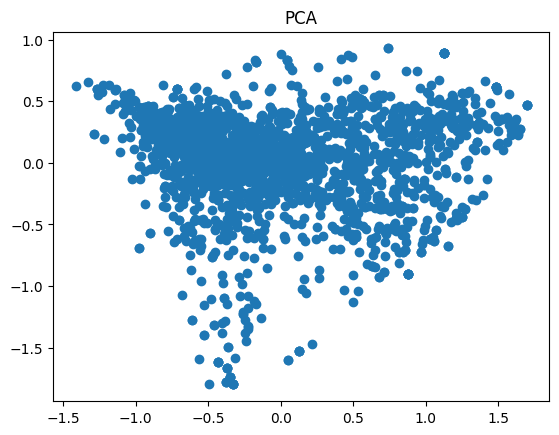

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


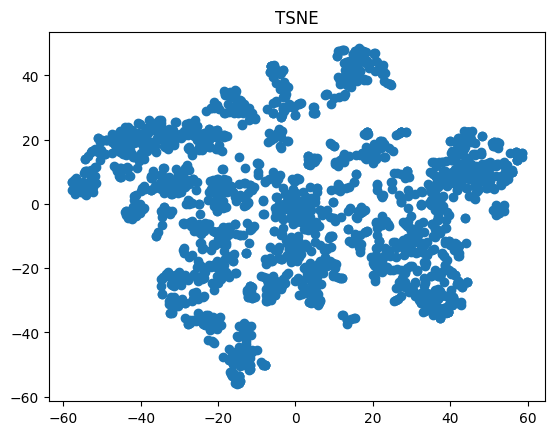

5 / 50
6 / 50
7 / 50
8 / 50
9 / 50
10 / 50
11 / 50
12 / 50
13 / 50
14 / 50
15 / 50
16 / 50
17 / 50
18 / 50
19 / 50
20 / 50
21 / 50
22 / 50
23 / 50
24 / 50
25 / 50
26 / 50
27 / 50
28 / 50
29 / 50
30 / 50
31 / 50
32 / 50
33 / 50
34 / 50
35 / 50
36 / 50
37 / 50
38 / 50
39 / 50
40 / 50
41 / 50
42 / 50
43 / 50
44 / 50
45 / 50
46 / 50
47 / 50
48 / 50
49 / 50


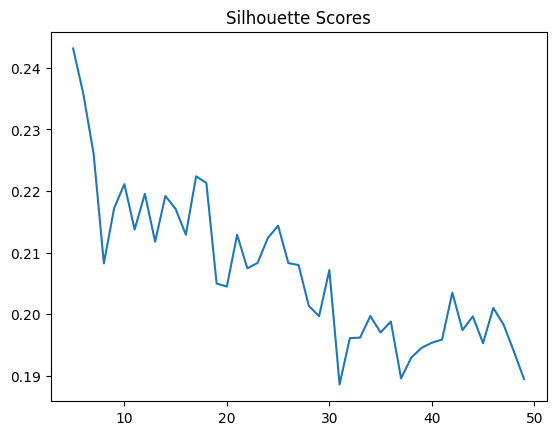

NMI: 0.22826154264247567


In [16]:
perform_kmeans(w2v_embeddings_all)

In [56]:
run_kmeans_best_k(5, w2v_embeddings_all)

Cluster 1 :
Cluster Size:========= 617
Sample Docs:=========
missing air conditioner compressor belt
alternator overcharging
drag generator overvoltage
air conditioner belt cover broken
pump drive universal joints noise

Top words:=========
air
conditioner
not
leaking
number

Top failure modes:=========
leaking
worn
failed
noisy
needs

Top equipment:=========
air conditioner
pulley
engine
brake
motor

Inherent functions in order:
holding (82)
guiding (81)
generating (65)
emitting (62)
driving (53)
transforming (49)
matterprocessing (40)
restricting (37)
protecting (32)
covering (30)
controlling (24)
storing (16)
presenting (15)
sensing (15)
interfacing (10)
humaninteraction (6)

Cluster 2 :
Cluster Size:========= 704
Sample Docs:=========
track pin coming out
hoist chain pin fell out
boom light out on first row from house
broken prelube bracket
headboard supports bent

Top words:=========
hand
broken
right
missing
left

Top failure modes:=========
broken
missing
cracked
out
loose

Top 

### Ave Hierarchical

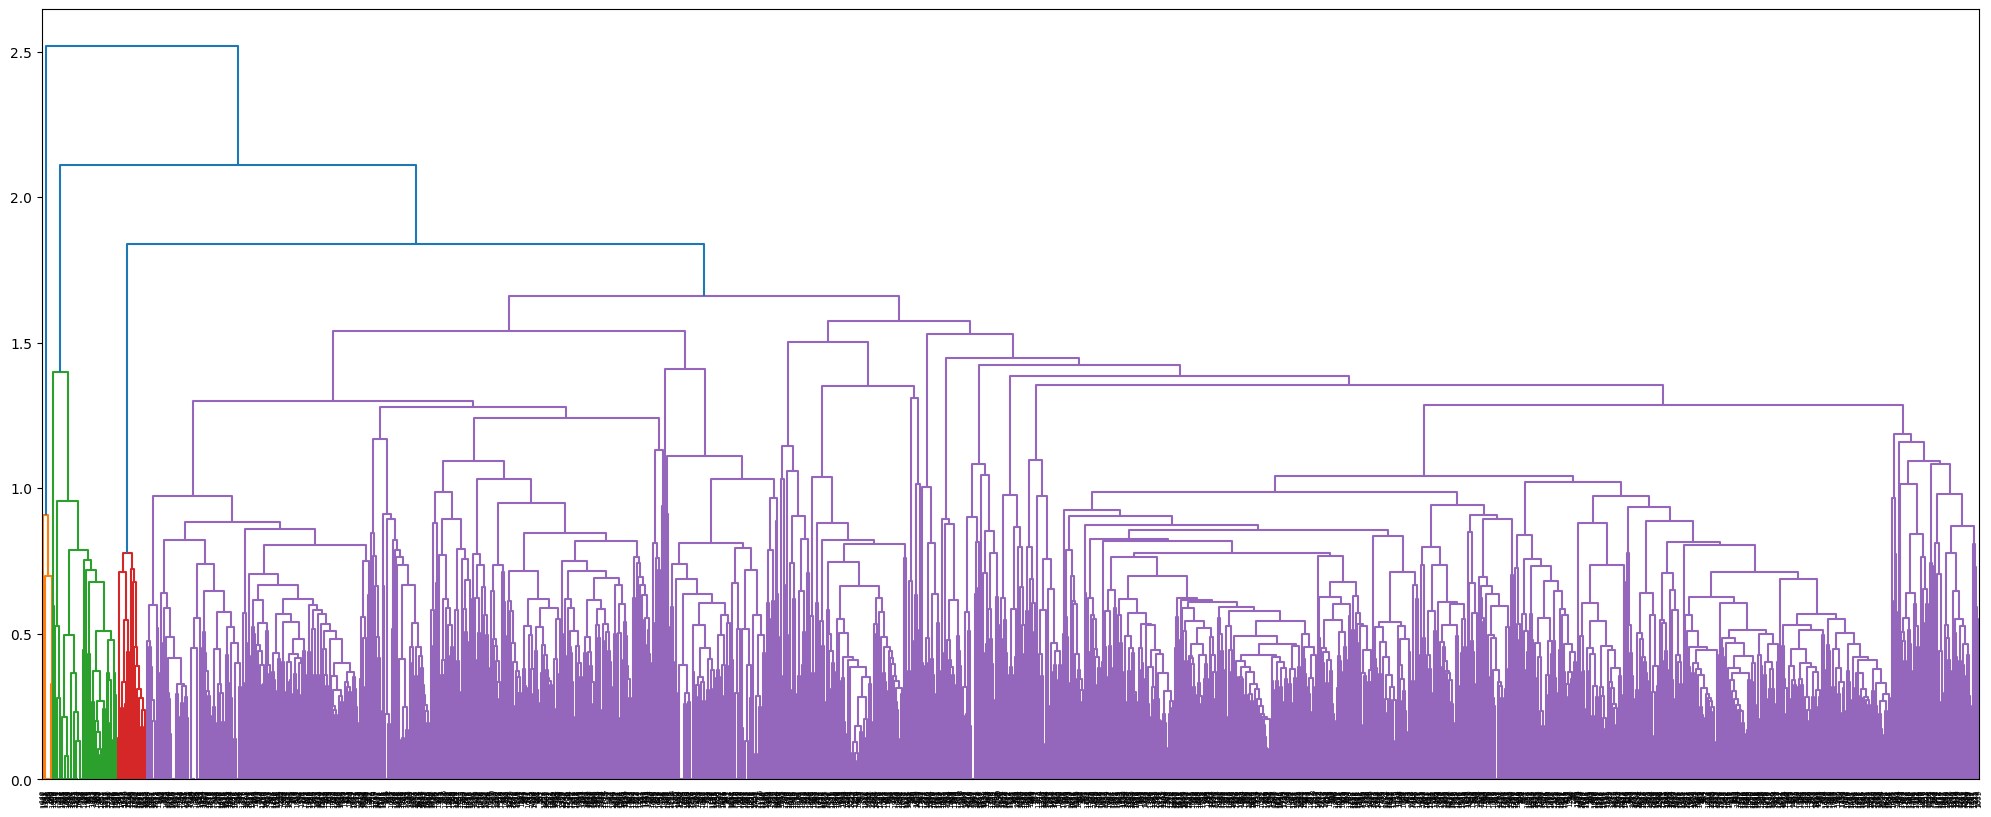

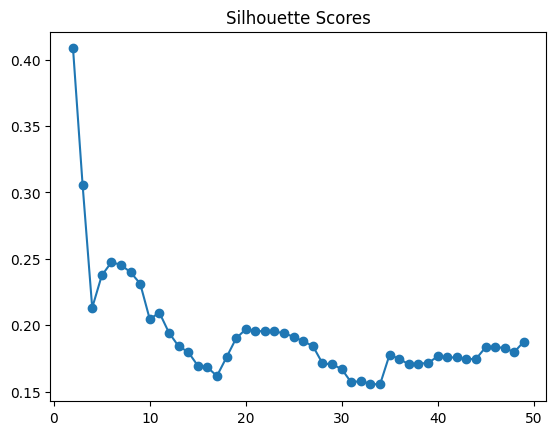

NMI: 0.2056617196776907


In [38]:
linkage_data_ave = perform_hierarchical_clustering(w2v_embeddings_all, "average")

In [57]:
get_hierarchical_clusters(6, linkage_data_ave)

Cluster 1 :
Cluster Size:========= 211
Sample Docs:=========
position blown tyre
position tyre damage
hydraulic hose leaking
blown hose no steering
blown main pump hose
leaking hose from torque converter lock up valve
blown air conditioner hose
brake cooling hose leaking
position tyre damage
position and tyre worn out

Top words:=========
hose
blown
leaking
position
tyre

Top failure modes:=========
blown
leaking
leak
broken
flat

Top equipment:=========
hose
tyre
brake
hydraulic hose
hoses

Inherent functions in order:
guiding (211)

Cluster 2 :
Cluster Size:========= 314
Sample Docs:=========
leaking water pump
minor transmission oil leak
transmission failed
coolant leak
failed circuit breaker
minor leak hydraulic pump
failed universal joints pump drive
hoist motor overtemperature
engine oil leak text
noisy swing motor

Top words:=========
leak
oil
engine
pump
coolant

Top failure modes:=========
leak
leaking
failed
leaks
overheating

Top equipment:=========
engine
oil
pump
coolant
t

### Ward Heirarchical

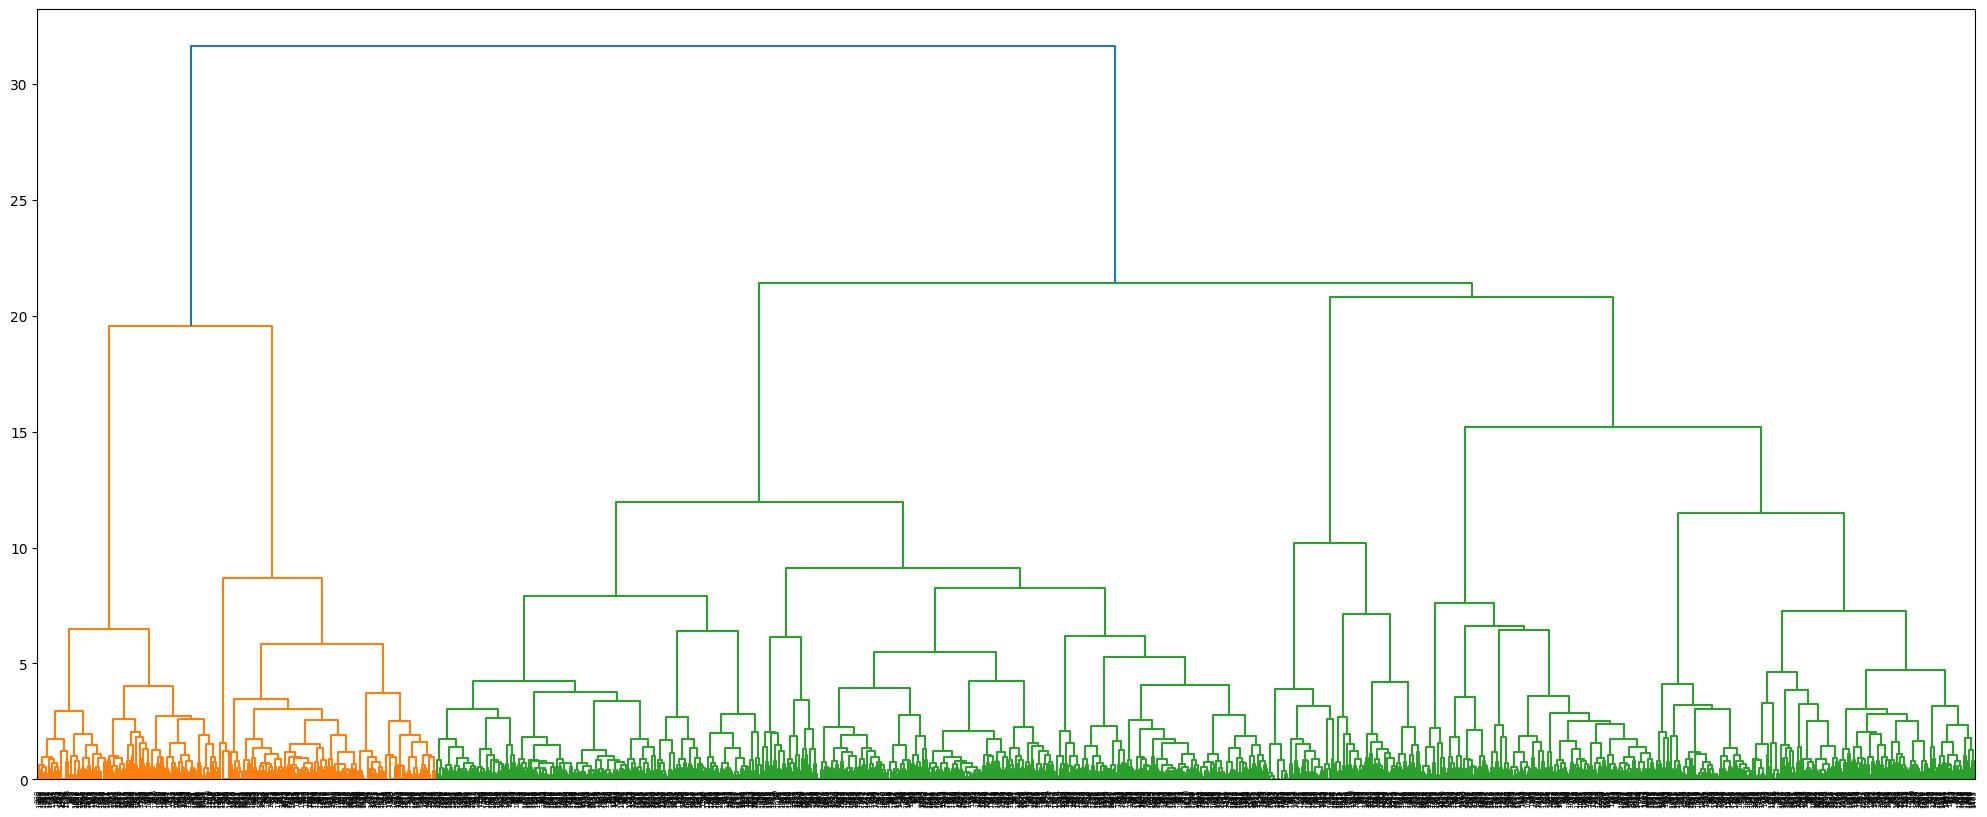

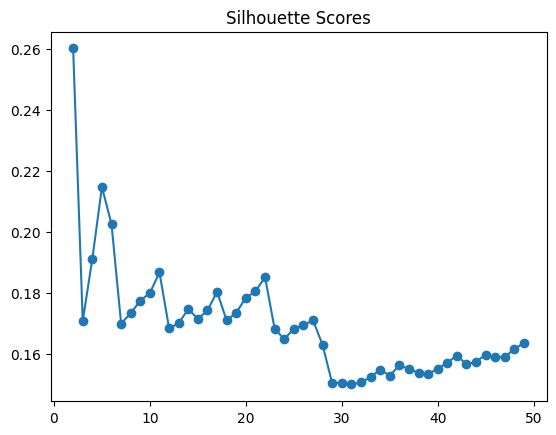

NMI: 0.22014303485650624


In [39]:
linkage_data_ward = perform_hierarchical_clustering(w2v_embeddings_all, "ward")

In [35]:
get_hierarchical_clusters(5, linkage_data_ward)

Cluster 1 :
Cluster Size:========= 373
Sample Docs:=========
right hand propel brake rubbing
cabin seat needs
lower left hand headlight blown
drivers door seal requires
broken window
left bottom light out
leaky left hand tilt cylinder hose
rear module work lights loose
dragging brakes
broken left hand side headlight

Top words:=========
hand
right
left
broken
side

Top failure modes:=========
broken
leaking
out
missing
damaged

Top equipment:=========
cabin
brake
window
door
light

Inherent functions in order:
holding (79)
emitting (66)
restricting (55)
guiding (45)
controlling (36)
covering (19)
driving (16)
interfacing (12)
protecting (11)
humaninteraction (8)
matterprocessing (7)
sensing (6)
storing (5)
presenting (3)
transforming (3)
generating (2)

Cluster 2 :
Cluster Size:========= 565
Sample Docs:=========
to swing plugging
seat base is stuffed /
/ creeping bucket
broken bolts
rear lube bay door broken
bolts out of cable handler
worn corner bucket teeth
universal joint behind ce

## SBERT Clustering

In [19]:
SBERT_embeddings_all = sbert.encode(X_train+X_test)

### K-means

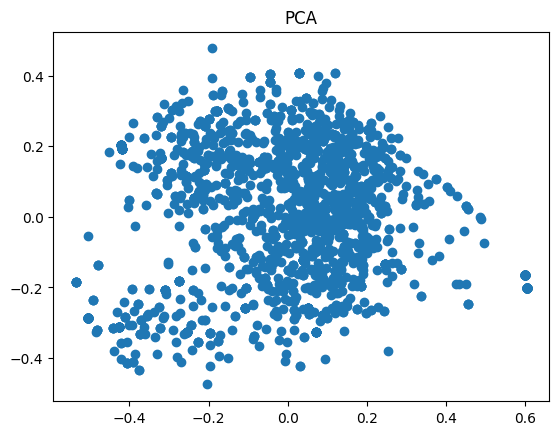

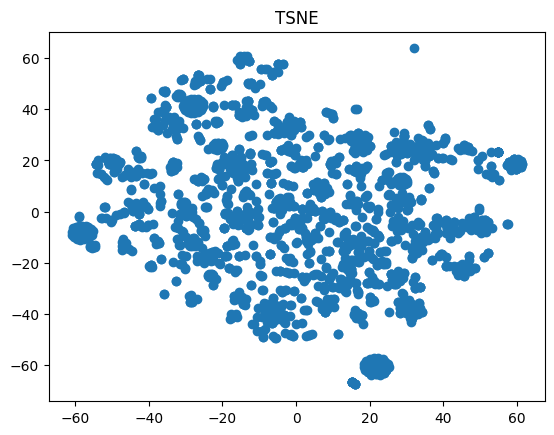

5 / 50
6 / 50
7 / 50
8 / 50
9 / 50
10 / 50
11 / 50
12 / 50
13 / 50
14 / 50
15 / 50
16 / 50
17 / 50
18 / 50
19 / 50
20 / 50
21 / 50
22 / 50
23 / 50
24 / 50
25 / 50
26 / 50
27 / 50
28 / 50
29 / 50
30 / 50
31 / 50
32 / 50
33 / 50
34 / 50
35 / 50
36 / 50
37 / 50
38 / 50
39 / 50
40 / 50
41 / 50
42 / 50
43 / 50
44 / 50
45 / 50
46 / 50
47 / 50
48 / 50
49 / 50


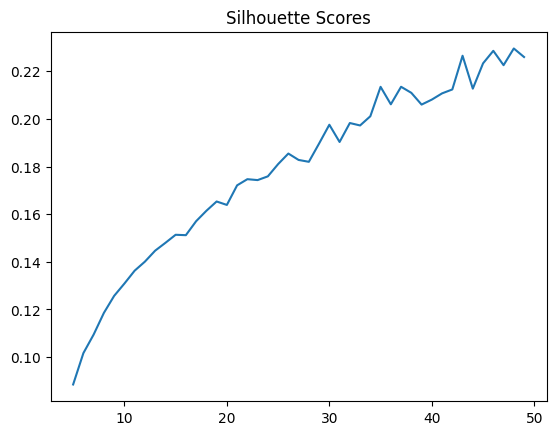

NMI: 0.17014017152708052


In [20]:
perform_kmeans(SBERT_embeddings_all)

In [40]:
run_kmeans_best_k(48, SBERT_embeddings_all)

Cluster 1 :
Cluster Size:========= 47
Sample Docs:=========
park brake staying on
brake pads and leaking booster
brake cooling return hose leaking
brake warning light on
brakes locked on

Top words:=========
brake
leaking
hose
brakes
on

Top failure modes:=========
leaking
not releasing
leak
dragging
stuck on

Top equipment:=========
brake
hose
brakes
park brake
cooling hose

Inherent functions in order:
restricting (22)
guiding (14)
emitting (4)
covering (2)
controlling (2)
presenting (1)
storing (1)
holding (1)

Cluster 2 :
Cluster Size:========= 52
Sample Docs:=========
air conditioner inoperable
air conditioner accessory drive leaking oil
air conditioner leaking water into cabin
air conditioner hose stolen for
air conditioner not operating

Top words:=========
air
conditioner
not
cold
leaking

Top failure modes:=========
leaking
not cold
blowing warm
freezing up
blocked

Top equipment:=========
air conditioner
compressor
drive
belt
oil

Inherent functions in order:
emitting (36)
ge

### Ave Hierarchical

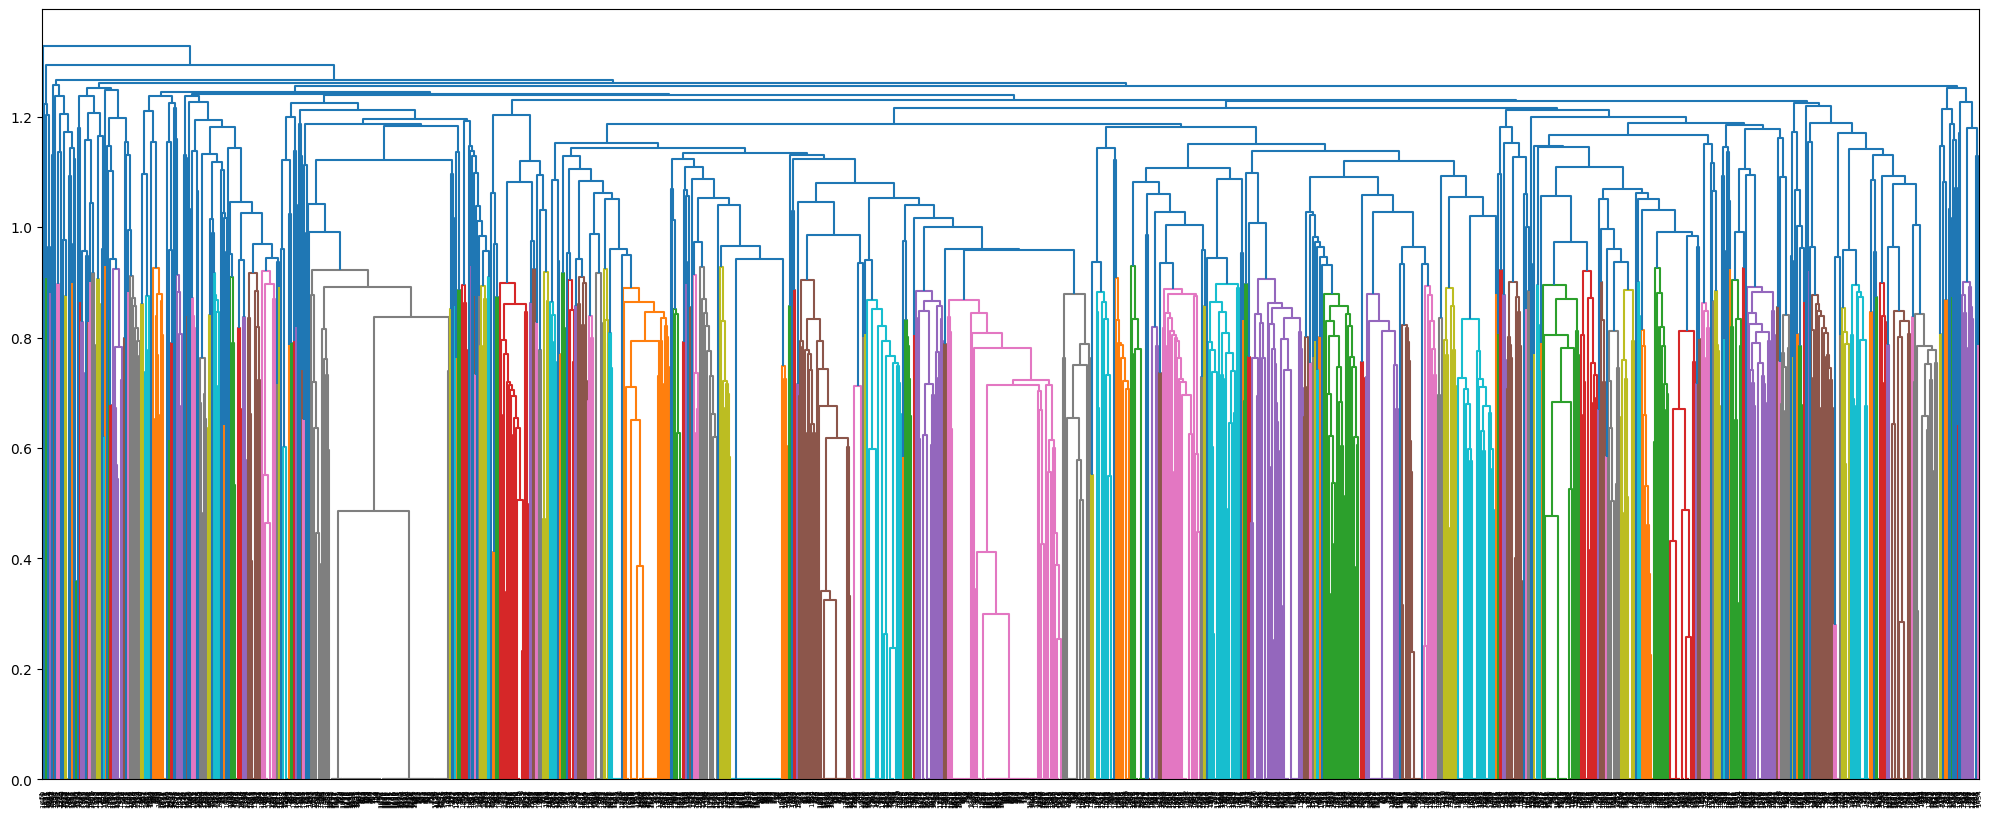

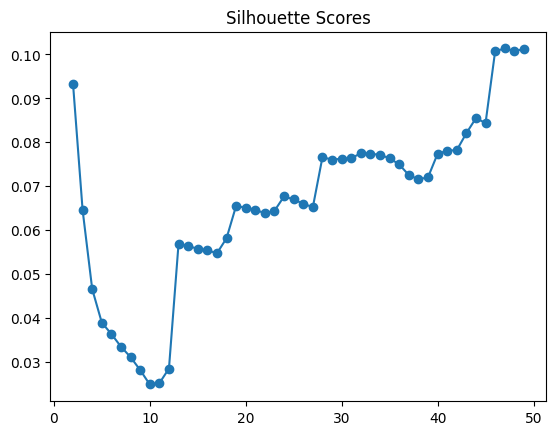

NMI: 0.08241429114162077


In [41]:
linkage_data_ave = perform_hierarchical_clustering(SBERT_embeddings_all, "average")

In [42]:
get_hierarchical_clusters(47, linkage_data_ave)

Cluster 1 :
Cluster Size:========= 2
Sample Docs:=========
VIMS keypad light out
VIMS error

Top words:=========
VIMS
keypad
light
out
error

Top failure modes:=========
out
error

Top equipment:=========
VIMS
light
keypad

Inherent functions in order:
emitting (1)
presenting (1)

Cluster 2 :
Cluster Size:========= 2
Sample Docs:=========
hoist has hot spot
hammer has bolts missing

Top words:=========
has
hoist
hot
spot
hammer

Top failure modes:=========
hot spot
missing

Top equipment:=========
hoist
hammer
bolts

Inherent functions in order:
generating (1)
holding (1)

Cluster 3 :
Cluster Size:========= 5
Sample Docs:=========
boom point light out
boom point sheave bumper rubber cracked
boom not lowering
no boom lights
both boom point lights out

Top words:=========
boom
point
lights
out
not

Top failure modes:=========
out
not lowering
no
cracked

Top equipment:=========
boom point
boom
lights
light
sheave

Inherent functions in order:
emitting (3)
holding (1)
covering (1)

Cluste

### Ward Hierarchical

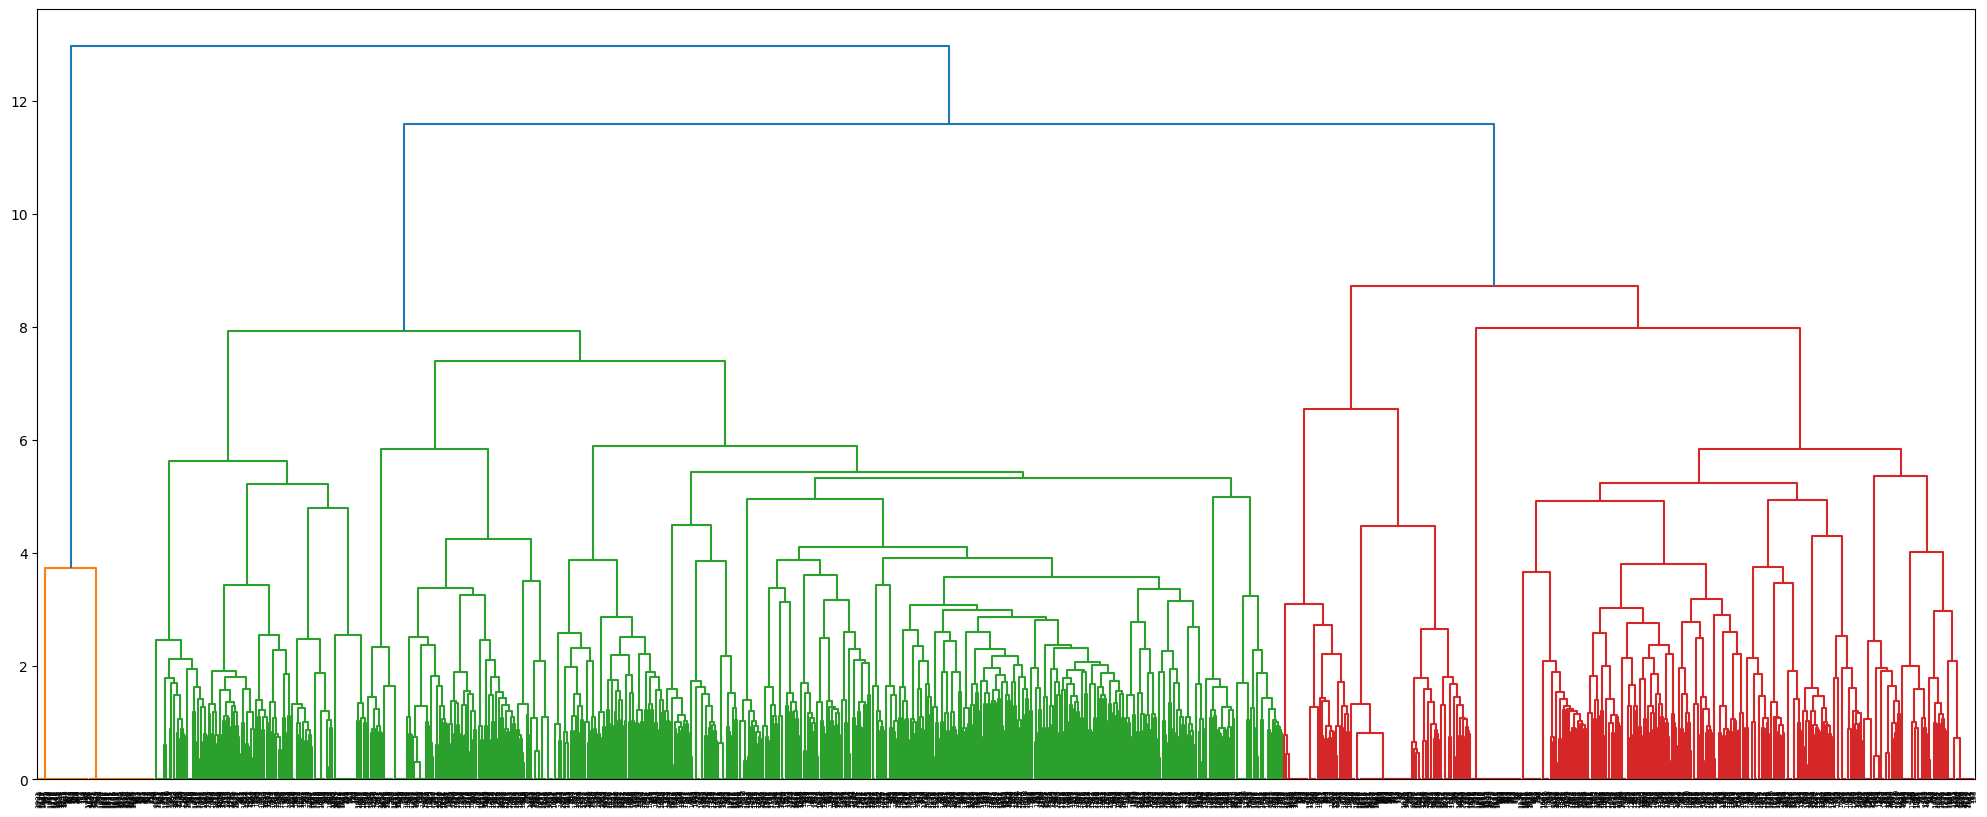

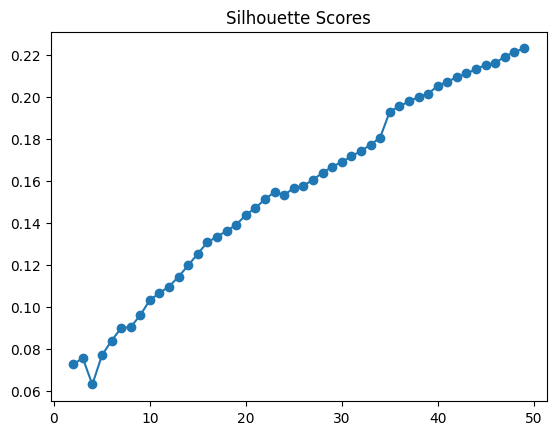

NMI: 0.16559225290451912


In [43]:
linkage_data_ward = perform_hierarchical_clustering(SBERT_embeddings_all, "ward")

In [44]:
get_hierarchical_clusters(49, linkage_data_ward)

Cluster 1 :
Cluster Size:========= 52
Sample Docs:=========
left hand final drive leaking at mount
left hand side inner fairlead frame cracked at top
left hand side large air tank fitting leaking
left hand external mirror bracket loose
left hand side headlight flashing
left hand corner bonnet cracked
left hand side bucket hitch pin missing
left hand broken mirror
left hand drag chain snapped in middle
left hand rear fan guard needs new hinges

Top words:=========
left
hand
rear
side
leaking

Top failure modes:=========
leaking
broken
loose
cracked
out

Top equipment:=========
cylinder
mount
frame
bolts
guard

Inherent functions in order:
holding (17)
guiding (12)
emitting (7)
driving (5)
controlling (3)
protecting (2)
covering (2)
storing (1)
matterprocessing (1)
humaninteraction (1)
interfacing (1)

Cluster 2 :
Cluster Size:========= 68
Sample Docs:=========
right hand propel brake rubbing
right hand mirror broken
right hand headlight out
right hand side headlight requires
right hand 

## w2v -> Inherent Function

### Create Cluster Embeddings

In [23]:
w2v_if_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(10,100)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(units=16, activation="softmax")
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

w2v_if_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_loss', restore_best_weights=True)
history = w2v_if_model.fit(w2v_embeddings_X_train, y_train, epochs=200, validation_data=(w2v_embeddings_X_test, y_test), callbacks=[early_stopping])

# run predictions
pred_train = w2v_if_model.predict(w2v_embeddings_X_train)
pred_train = pred_train.argmax(axis=-1)
print("Final train accuracy:", w2v_if_model.evaluate(w2v_embeddings_X_train, y_train)[1])

pred_test = w2v_if_model.predict(w2v_embeddings_X_test)
pred_test = pred_test.argmax(axis=-1)
print("Final test accuracy:", w2v_if_model.evaluate(w2v_embeddings_X_test, y_test)[1])

Epoch 1/200
50/50 [==============================] - 4s 21ms/step - loss: 2.4932 - accuracy: 0.1875 - val_loss: 2.2560 - val_accuracy: 0.3073
Epoch 2/200
50/50 [==============================] - 0s 8ms/step - loss: 2.1568 - accuracy: 0.3561 - val_loss: 2.0490 - val_accuracy: 0.4106
Epoch 3/200
50/50 [==============================] - 0s 9ms/step - loss: 1.9585 - accuracy: 0.4312 - val_loss: 1.8979 - val_accuracy: 0.4559
Epoch 4/200
50/50 [==============================] - 0s 8ms/step - loss: 1.8719 - accuracy: 0.4514 - val_loss: 1.8519 - val_accuracy: 0.4484
Epoch 5/200
50/50 [==============================] - 0s 8ms/step - loss: 1.7656 - accuracy: 0.4760 - val_loss: 1.7694 - val_accuracy: 0.4559
Epoch 6/200
50/50 [==============================] - 0s 8ms/step - loss: 1.6856 - accuracy: 0.4874 - val_loss: 1.7098 - val_accuracy: 0.4836
Epoch 7/200
50/50 [==============================] - 0s 8ms/step - loss: 1.6584 - accuracy: 0.4912 - val_loss: 1.6565 - val_accuracy: 0.4887
Epoch 8/200


In [24]:
w2v_if_model_embedding = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(10,100)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(10, activation='relu')
])

w2v_if_model_embedding.layers[0].set_weights(w2v_if_model.layers[0].get_weights())
w2v_if_model_embedding.layers[1].set_weights(w2v_if_model.layers[1].get_weights())
w2v_if_model_embedding.layers[2].set_weights(w2v_if_model.layers[2].get_weights())
w2v_if_model_embedding.layers[3].set_weights(w2v_if_model.layers[3].get_weights())

w2v_embeddings = np.concatenate((w2v_embeddings_X_train, w2v_embeddings_X_test))
cluster_embeddings1 = w2v_if_model_embedding.predict(w2v_embeddings)
print(cluster_embeddings1.shape)

62/62 [==============================] - 1s 2ms/step
(1981, 10)


### K-means

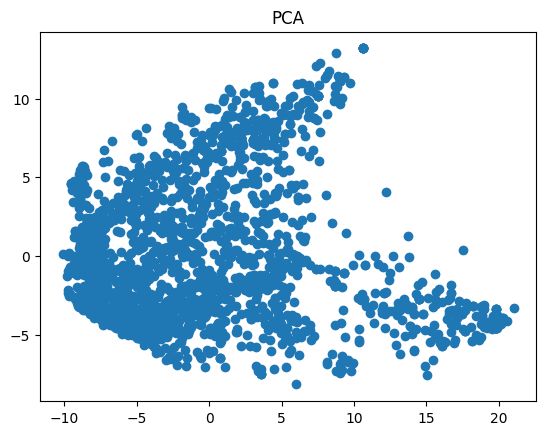

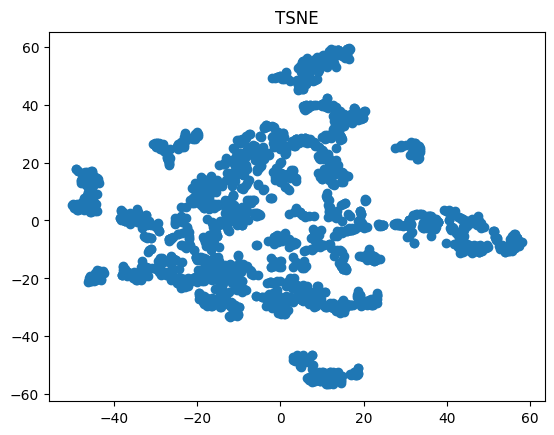

5 / 50
6 / 50
7 / 50
8 / 50
9 / 50
10 / 50
11 / 50
12 / 50
13 / 50
14 / 50
15 / 50
16 / 50
17 / 50
18 / 50
19 / 50
20 / 50
21 / 50
22 / 50
23 / 50
24 / 50
25 / 50
26 / 50
27 / 50
28 / 50
29 / 50
30 / 50
31 / 50
32 / 50
33 / 50
34 / 50
35 / 50
36 / 50
37 / 50
38 / 50
39 / 50
40 / 50
41 / 50
42 / 50
43 / 50
44 / 50
45 / 50
46 / 50
47 / 50
48 / 50
49 / 50


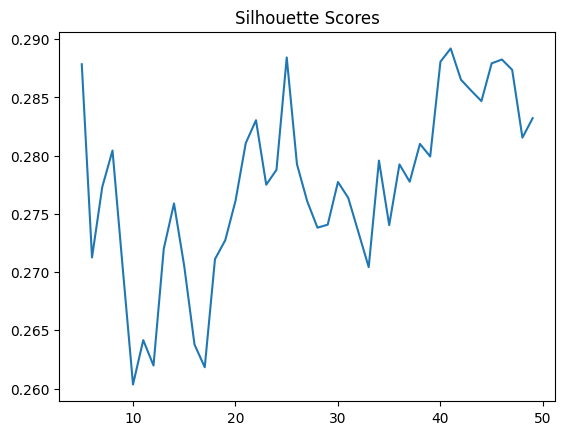

NMI: 0.43951374962356815


In [25]:
perform_kmeans(cluster_embeddings1)

In [45]:
run_kmeans_best_k(41, cluster_embeddings1)

Cluster 1 :
Cluster Size:========= 108
Sample Docs:=========
x catwalk bolts on side missing
right hand sheave retainer plate bolts broken
tub cable damaged
left hand front cam frame bolts loose
hydraulic breakout has bent pin

Top words:=========
hand
missing
bolts
right
pin

Top failure modes:=========
missing
loose
broken
damaged
bent

Top equipment:=========
bolts
pin
rope
bolt
cabin

Inherent functions in order:
holding (95)
guiding (5)
covering (3)
controlling (1)
interfacing (1)
emitting (1)
storing (1)
generating (1)

Cluster 2 :
Cluster Size:========= 55
Sample Docs:=========
hose right hand side below deflection tower weep
damaged position tyre and position
left hand drag chain snapped in middle
tyre to be under damage
position damaged tyre

Top words:=========
position
tyre
damaged
hand
chain

Top failure modes:=========
damaged
broken
damage
snapped
mismatched

Top equipment:=========
tyre
chain
drag
hose
exhaust

Inherent functions in order:
guiding (50)
protecting (4)
con

### Ave Hierarchical

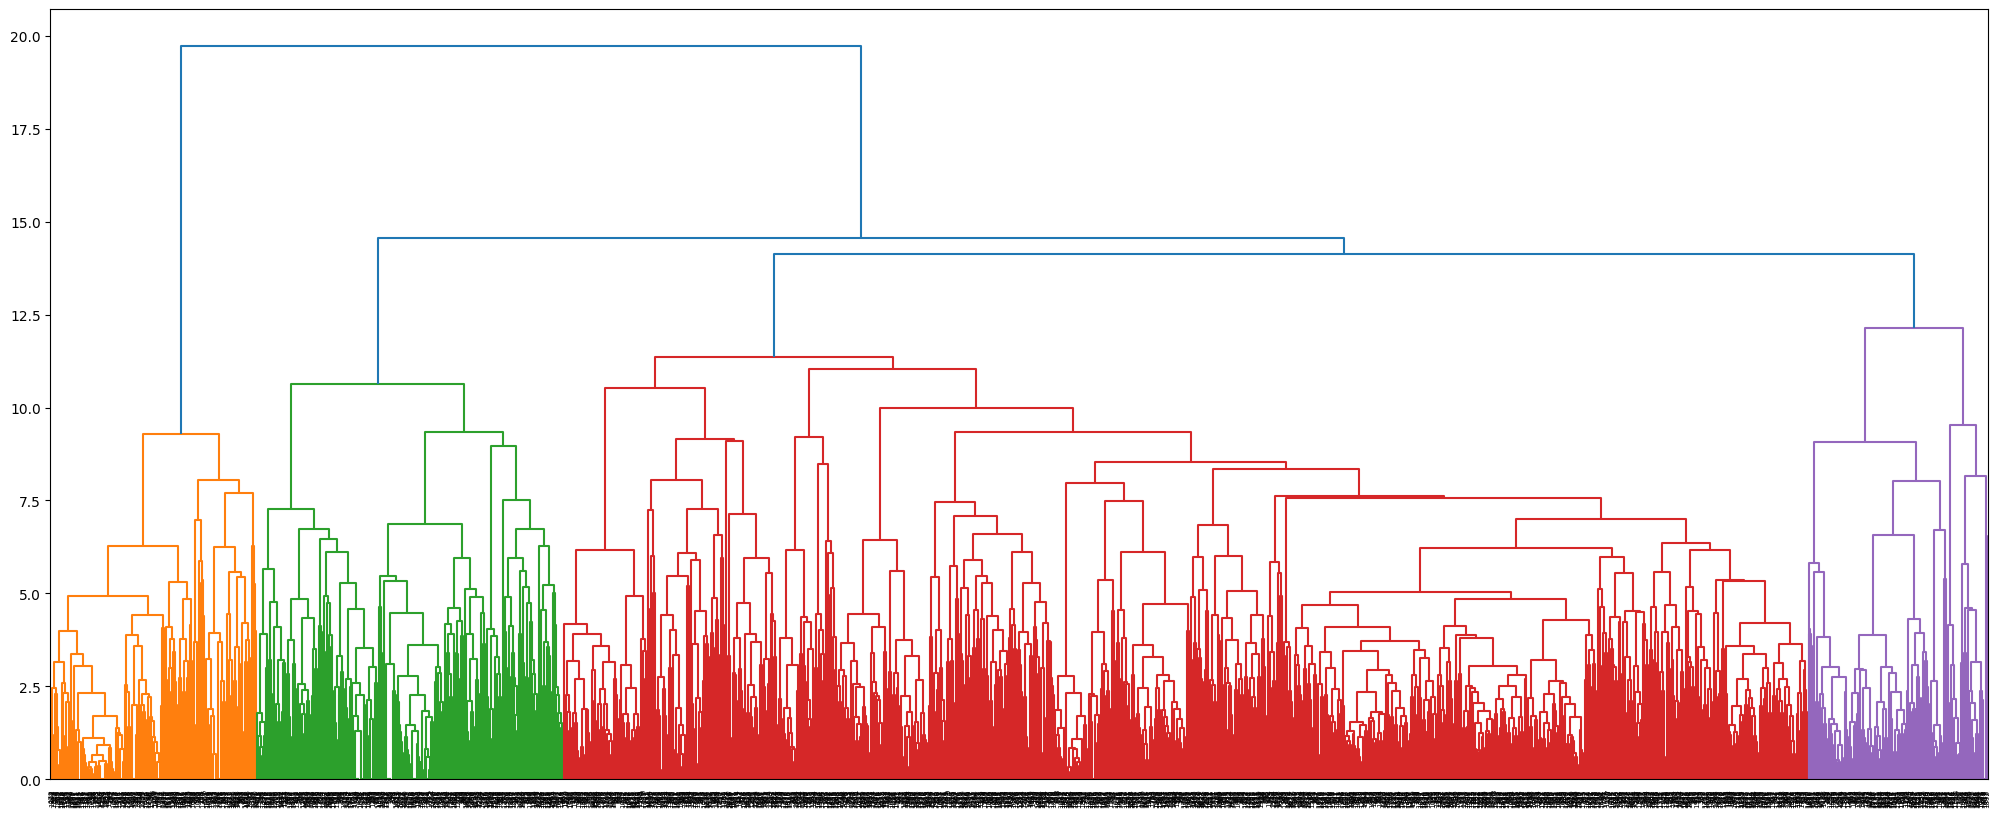

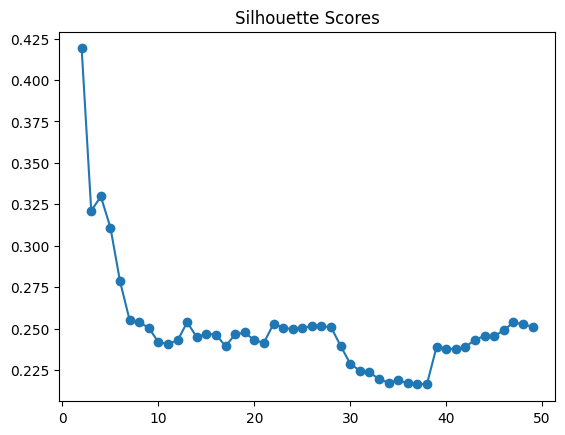

NMI: 0.44669481265404115


In [46]:
linkage_data_ave = perform_hierarchical_clustering(cluster_embeddings1, "average")

In [47]:
get_hierarchical_clusters(4, linkage_data_ave)

Cluster 1 :
Cluster Size:========= 211
Sample Docs:=========
position brake hose leak
fan hose leaking
tram hose blown
blown hoist screen hose PO
intake hose rubbed through
blown hose
steering hose worn
blown hydraulic hose on trailer
exhaust leak
hydraulic hose leaking

Top words:=========
hose
blown
leaking
position
tyre

Top failure modes:=========
blown
leaking
leak
broken
flat

Top equipment:=========
hose
tyre
brake
hydraulic hose
hoses

Inherent functions in order:
guiding (211)

Cluster 2 :
Cluster Size:========= 314
Sample Docs:=========
reported hydraulic oil leak at rear
coolant leak at position turbo
engine shutting down
grease distributor leaking
rear differential failed
hydraulic pump noise
engine oil leak
ongoing coolant leak
hydraulic oil leak at axle
engine over heating

Top words:=========
leak
oil
engine
pump
coolant

Top failure modes:=========
leak
leaking
failed
leaks
overheating

Top equipment:=========
engine
oil
pump
coolant
transmission

Inherent functions in 

### Ward Hierarchical

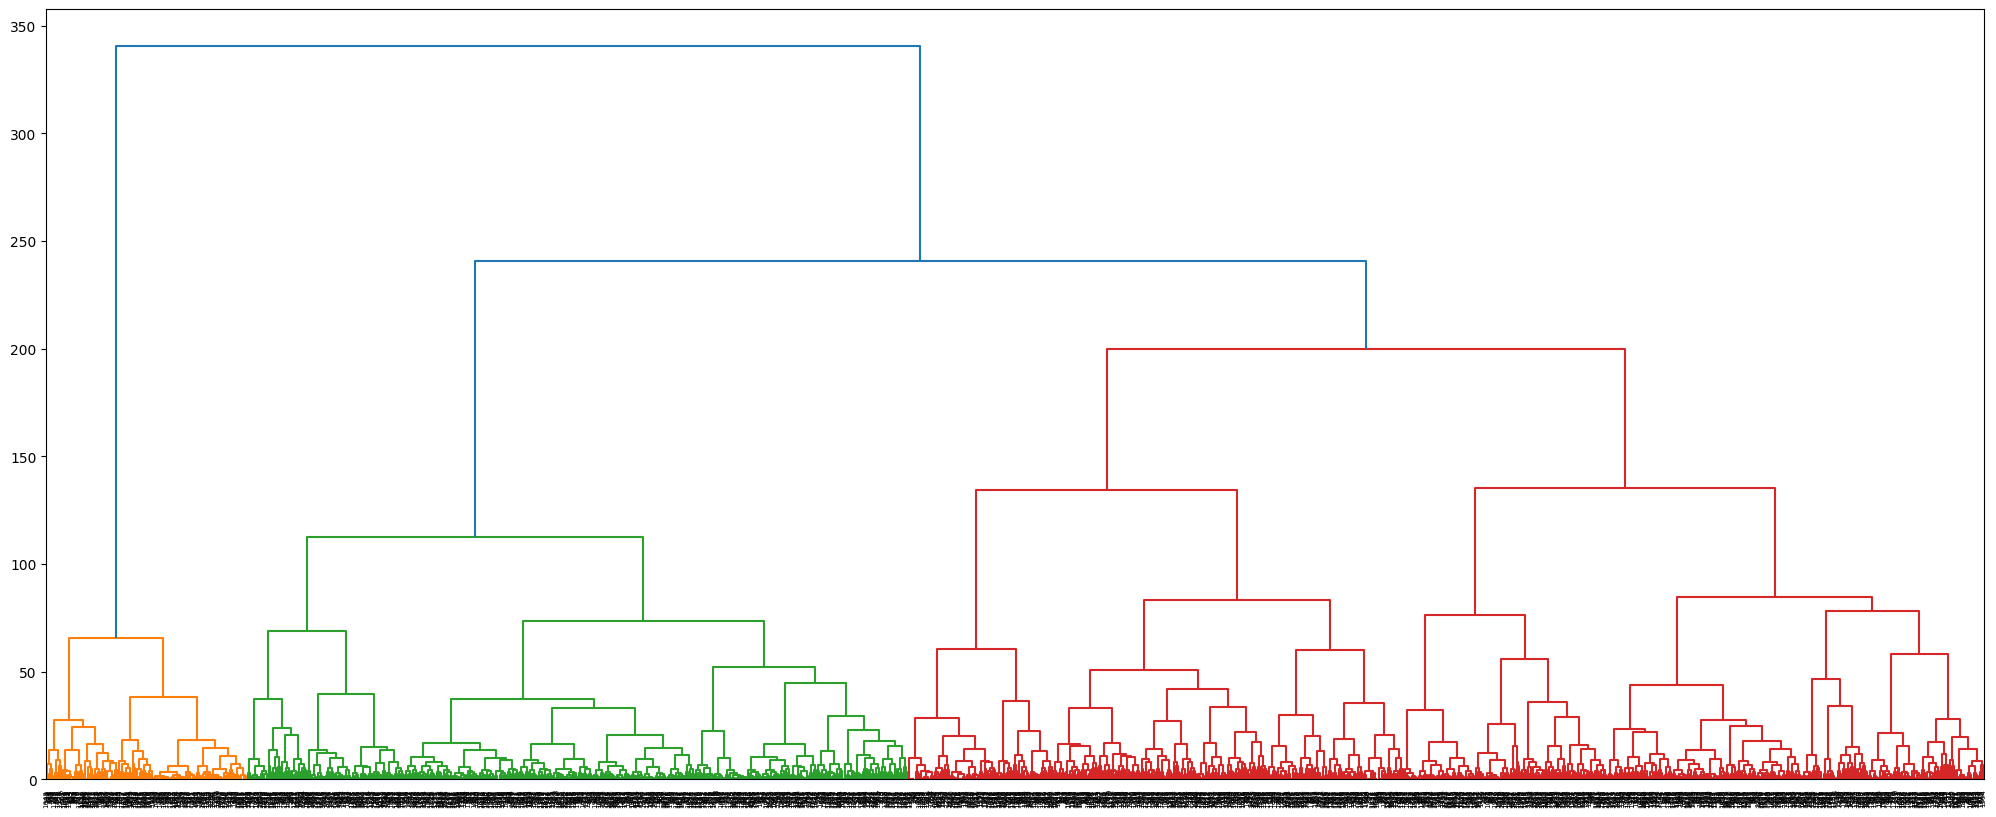

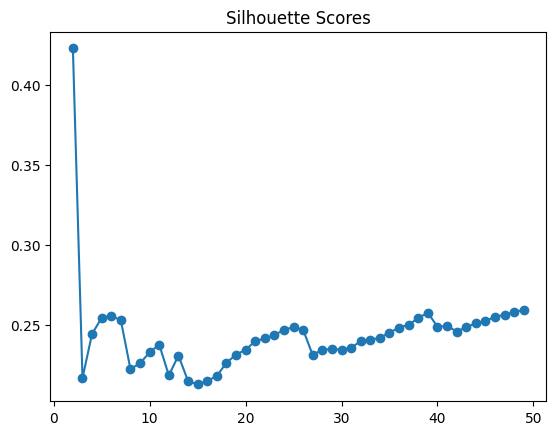

NMI: 0.43073678849399655


In [48]:
linkage_data_ward = perform_hierarchical_clustering(cluster_embeddings1, "ward")

In [50]:
get_hierarchical_clusters(6, linkage_data_ward)

Cluster 1 :
Cluster Size:========= 205
Sample Docs:=========
blown main hydraulic hose
grease hoses damaged fairlead
left hand boom cylinder hose leaking PO
differential cooler fan hose leaking
hydraulic hose leaking in centre of machine
damaged hoses
blown hose position end
blown implement hose
blown hydraulic hose
exhaust leak

Top words:=========
hose
blown
leaking
position
tyre

Top failure modes:=========
blown
leaking
broken
leak
flat

Top equipment:=========
hose
tyre
brake
hydraulic hose
hoses

Inherent functions in order:
guiding (205)

Cluster 2 :
Cluster Size:========= 676
Sample Docs:=========
cracks on stick
number swing brake pads worn
crack left hand side back of the arch
no excitation on hoist
right hand side tooth and adaptor missing
air and pneumatic air tank fell off
number right hand air brake line needs
left hand front cam frame bolts loose
steering wheel cover missing
broken air conditioner guard

Top words:=========
hand
broken
missing
cracked
on

Top failure mod

## SBERT -> Inherent Function

### Create Cluster Embeddings

In [28]:
sbert_if_model = tf.keras.Sequential([
    
    tf.keras.layers.Dense(units=128, activation="tanh", input_shape=(768,)),
    tf.keras.layers.Dense(units=64, activation="tanh"),
    tf.keras.layers.Dense(units=32, activation="tanh"),

    tf.keras.layers.Dense(units=10, activation="tanh"),
    tf.keras.layers.Dense(units=16, activation="softmax")
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

sbert_if_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_loss', restore_best_weights=True)
history = sbert_if_model.fit(SBERT_embeddings_train, y_train, epochs=200, validation_data=(SBERT_embeddings_test, y_test), callbacks=[early_stopping])

# do predictions
pred_train = sbert_if_model.predict(SBERT_embeddings_train)
pred_train = pred_train.argmax(axis=-1)
print("training accuracy", sbert_if_model.evaluate(SBERT_embeddings_train, y_train)[1])

pred_test = sbert_if_model.predict(SBERT_embeddings_test)
pred_test = pred_test.argmax(axis=-1)
print("test accuracy", sbert_if_model.evaluate(SBERT_embeddings_test, y_test)[1])


Epoch 1/200
50/50 [==============================] - 1s 3ms/step - loss: 2.4653 - accuracy: 0.2677 - val_loss: 2.2620 - val_accuracy: 0.3929
Epoch 2/200
50/50 [==============================] - 0s 2ms/step - loss: 2.1248 - accuracy: 0.4230 - val_loss: 2.0889 - val_accuracy: 0.4257
Epoch 3/200
50/50 [==============================] - 0s 2ms/step - loss: 1.9228 - accuracy: 0.4899 - val_loss: 1.9827 - val_accuracy: 0.4433
Epoch 4/200
50/50 [==============================] - 0s 2ms/step - loss: 1.7700 - accuracy: 0.5253 - val_loss: 1.9423 - val_accuracy: 0.4761
Epoch 5/200
50/50 [==============================] - 0s 2ms/step - loss: 1.6595 - accuracy: 0.5486 - val_loss: 1.8930 - val_accuracy: 0.4660
Epoch 6/200
50/50 [==============================] - 0s 2ms/step - loss: 1.5639 - accuracy: 0.5713 - val_loss: 1.8544 - val_accuracy: 0.4962
Epoch 7/200
50/50 [==============================] - 0s 2ms/step - loss: 1.4857 - accuracy: 0.6073 - val_loss: 1.8370 - val_accuracy: 0.5013
Epoch 8/200
5

In [29]:
# get hidden layer model 
sbert_if_model_embedding = tf.keras.Sequential([
    
    tf.keras.layers.Dense(units=128, activation="tanh", input_shape=(768,)),
    tf.keras.layers.Dense(units=64, activation="tanh"),
    tf.keras.layers.Dense(units=32, activation="tanh"),

    tf.keras.layers.Dense(units=10, activation="tanh"),
])


sbert_if_model_embedding.layers[0].set_weights(sbert_if_model.layers[0].get_weights())
sbert_if_model_embedding.layers[1].set_weights(sbert_if_model.layers[1].get_weights())
sbert_if_model_embedding.layers[2].set_weights(sbert_if_model.layers[2].get_weights())
sbert_if_model_embedding.layers[3].set_weights(sbert_if_model.layers[3].get_weights())


SBERT_embeddings = np.concatenate((SBERT_embeddings_train, SBERT_embeddings_test))
cluster_embeddings2 = sbert_if_model_embedding.predict(SBERT_embeddings)
print(cluster_embeddings2.shape)


62/62 [==============================] - 0s 612us/step
(1981, 10)


### K-means

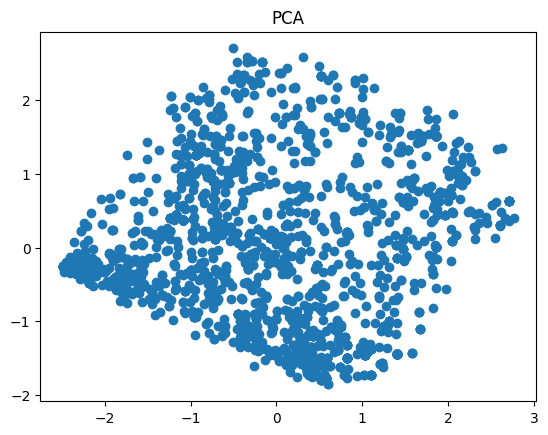

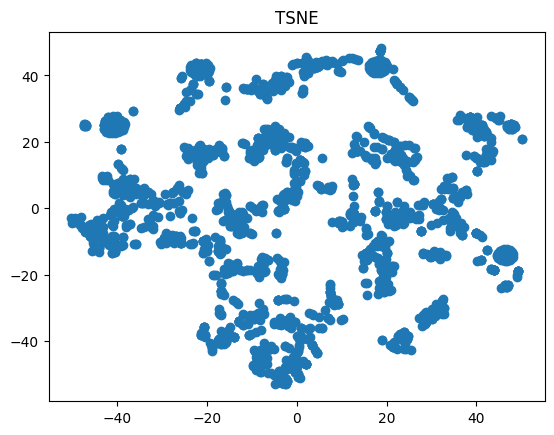

5 / 50
6 / 50
7 / 50
8 / 50
9 / 50
10 / 50
11 / 50
12 / 50
13 / 50
14 / 50
15 / 50
16 / 50
17 / 50
18 / 50
19 / 50
20 / 50
21 / 50
22 / 50
23 / 50
24 / 50
25 / 50
26 / 50
27 / 50
28 / 50
29 / 50
30 / 50
31 / 50
32 / 50
33 / 50
34 / 50
35 / 50
36 / 50
37 / 50
38 / 50
39 / 50
40 / 50
41 / 50
42 / 50
43 / 50
44 / 50
45 / 50
46 / 50
47 / 50
48 / 50
49 / 50


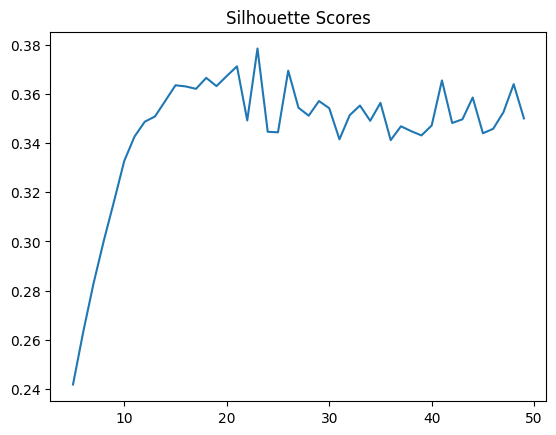

NMI: 0.39945727136867487


In [30]:
perform_kmeans(cluster_embeddings2)

In [51]:
run_kmeans_best_k(23, cluster_embeddings2)

Cluster 1 :
Cluster Size:========= 63
Sample Docs:=========
PTO accessory drive seal leaking
blown o-ring on steering pump
low steering pressure
blown o-ring on steering pump
top steering box seal leaking

Top words:=========
leaking
o-ring
differential
seal
blown

Top failure modes:=========
leaking
blown
leak
loose
missing

Top equipment:=========
o-ring
differential
seal
steering
oil

Inherent functions in order:
covering (38)
transforming (11)
holding (5)
controlling (3)
storing (3)
emitting (1)
driving (1)
matterprocessing (1)

Cluster 2 :
Cluster Size:========= 72
Sample Docs:=========
coolant leak at heater
and coolant leak on engine
coolant leak position turbo
coolant leak
CW coolant leak from radiator

Top words:=========
coolant
leak
system
grease
from

Top failure modes:=========
leak
blown
needs
cracked
leaks

Top equipment:=========
coolant
engine
grease system
hose
hydraulic oil

Inherent functions in order:
protecting (56)
guiding (8)
emitting (3)
driving (2)
generating 

### Ave Hierachical

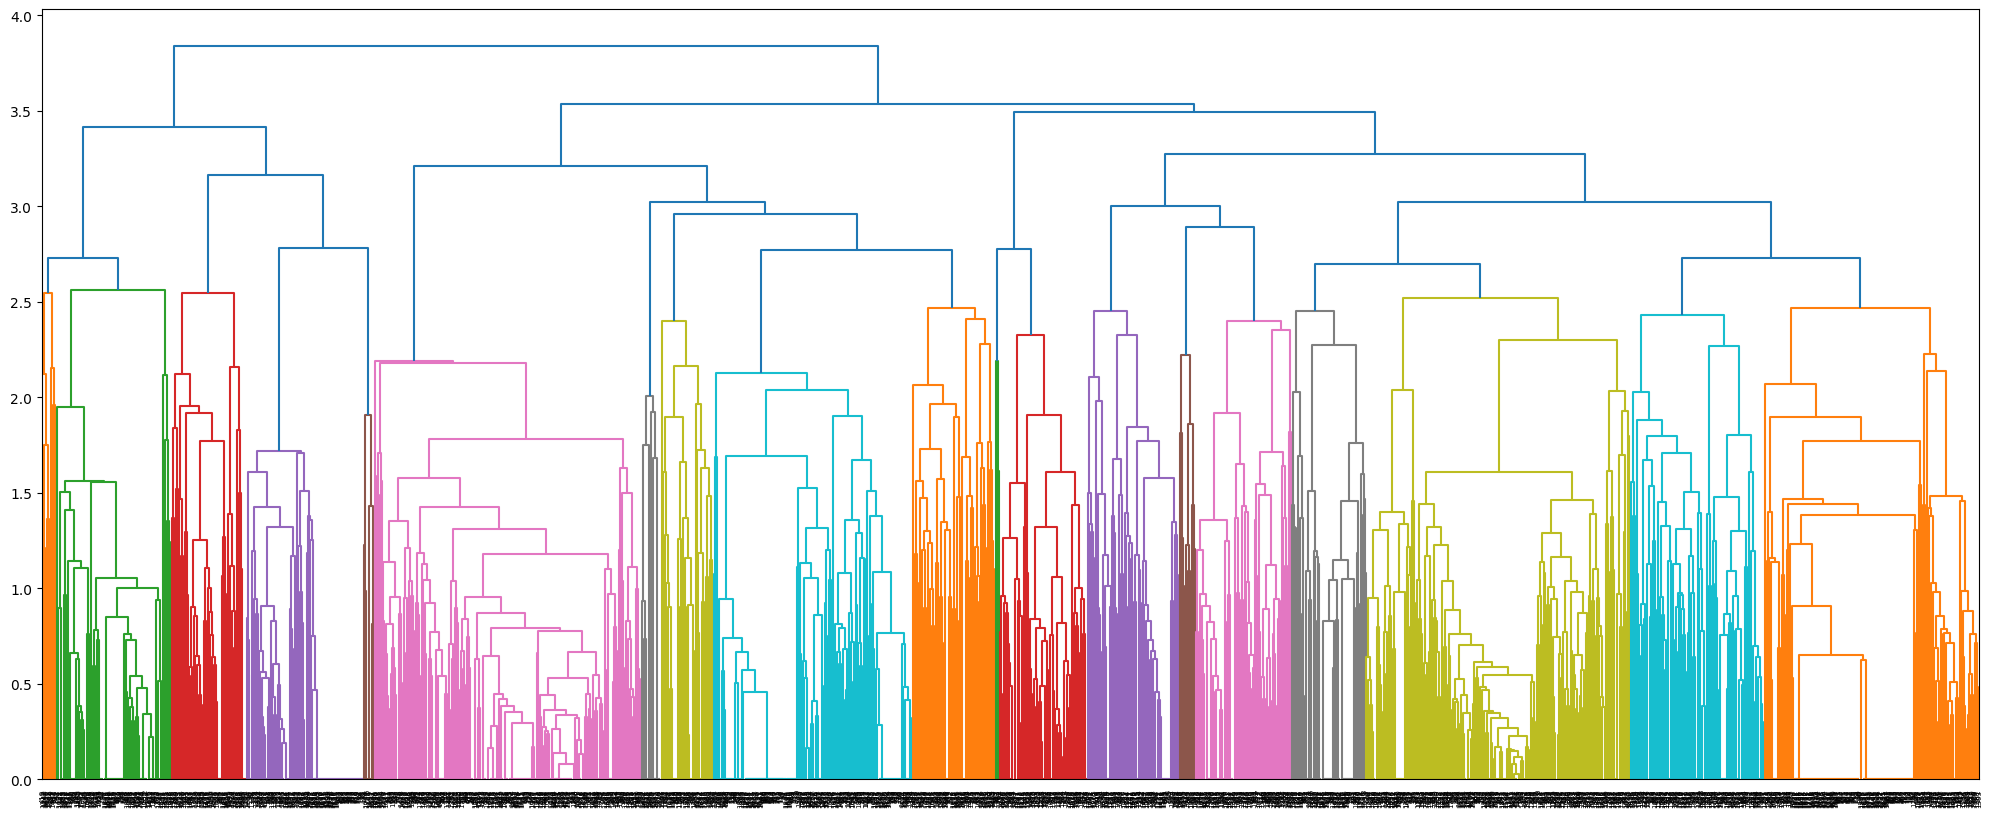

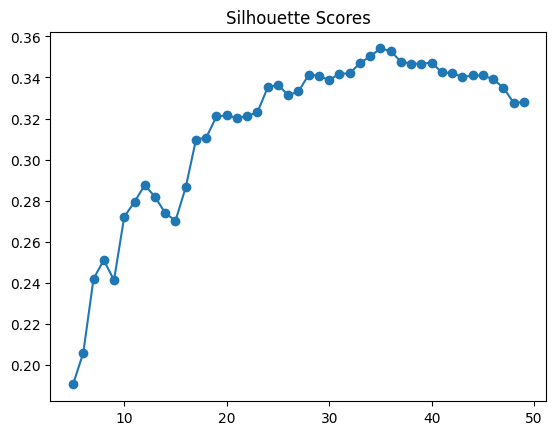

NMI: 0.37532335286269763


In [31]:
linkage_data_ave = perform_hierarchical_clustering(cluster_embeddings2, "average")

In [52]:
get_hierarchical_clusters(35, linkage_data_ave)

Cluster 1 :
Cluster Size:========= 145
Sample Docs:=========
hydraulic return manifold hose blow
blown hose on quick hitch
grease lines missing
blown right hand steering hose
blown implement hose
blown hose
blown main steering pump hose
blown park brake hose
damaged cooling hose
blown hose no steering

Top words:=========
hose
blown
leaking
hydraulic
brake

Top failure modes:=========
blown
leaking
broken
leak
worn

Top equipment:=========
hose
hydraulic hose
brake
cooling hose
steering

Inherent functions in order:
guiding (145)

Cluster 2 :
Cluster Size:========= 14
Sample Docs:=========
failed servo hose
transmission hoses leaking and brittle
fan motor hose leaking
differential cooler hose leaking
engine fan hose weeping
differential pump motor hose leaking
transmission hoses weeping
leak slew motor hose
torque convertor charge hose leak
transmission hoses oil leaks

Top words:=========
hose
leaking
transmission
hoses
differential

Top failure modes:=========
leaking
leaks
leak
weep

### Ward Hierarchical

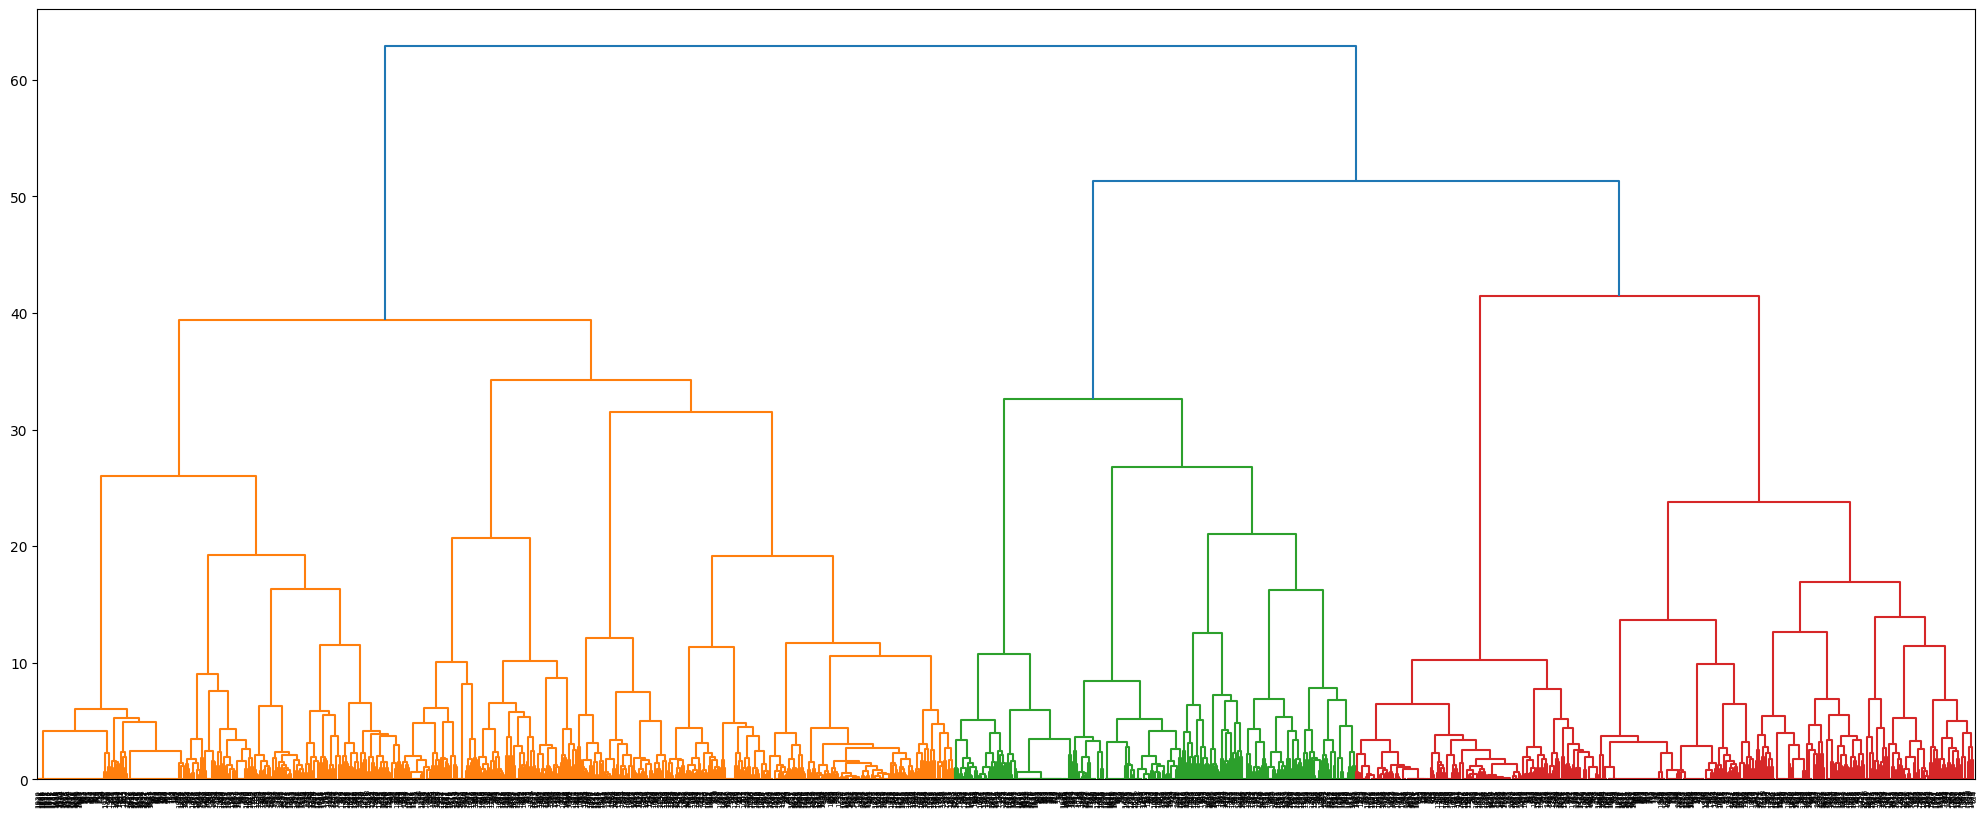

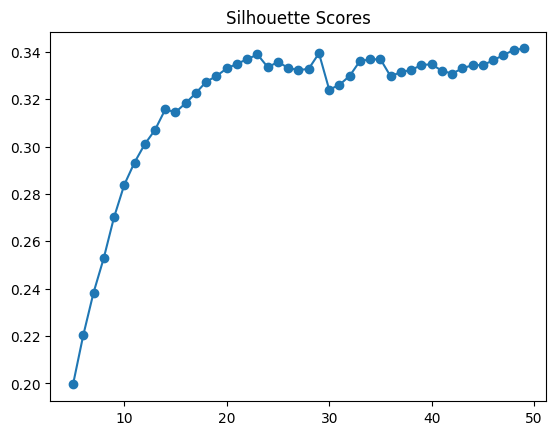

NMI: 0.3799383596904888


In [32]:
linkage_data_ward = perform_hierarchical_clustering(cluster_embeddings2, "ward")

In [53]:
get_hierarchical_clusters(29, linkage_data_ward)

Cluster 1 :
Cluster Size:========= 73
Sample Docs:=========
worn position tyre
position flat tyre
differential cooler fan hose leaking
flat tyre
hydraulic hose will not release
transmission hoses oil leaks
position tyre damage
exhaust leak
transmission hoses leaking
failed servo hose

Top words:=========
hose
position
tyre
leaking
grease

Top failure modes:=========
leaking
broken
flat
leak
worn

Top equipment:=========
hose
tyre
grease lines
lines
hoses

Inherent functions in order:
guiding (73)

Cluster 2 :
Cluster Size:========= 36
Sample Docs:=========
blown steering hose right hand side
intake hose rubbed through
blown steering pump hose
heater hose blown near tapes in
leaking tilt cylinder hose
hydraulic piping and hoses bucket hose blown
left hand rear brake cooling hose leaking
chaffing hoses
leaking transmission hose
leaky left hand tilt cylinder hose

Top words:=========
hose
blown
leaking
cylinder
steering

Top failure modes:=========
blown
leaking
weeping
leaky
rubbed throu